# Installation

Python version: python3.8 -q

TODO :
What should I do with this?

In [ ]:
import pandas as pd
import ast

# Assuming your DataFrame is named 'data' and the column with the lists is named 'score'

# Step 1: Convert the string representation of lists into actual lists
data['score'] = data['score'].apply(ast.literal_eval)
data['APE'] = data['APE'].apply(ast.literal_eval)
data['SIGN'] = data['SIGN'].apply(ast.literal_eval)


# Step 2: Create a DataFrame from the lists and expand the columns
score_df = pd.DataFrame(data['score'].tolist(), index=data.index)
ape_df = pd.DataFrame(data['APE'].tolist(), index=data.index)
sign_df = pd.DataFrame(data['SIGN'].tolist(), index=data.index)

# Step 3: Rename the columns to SCORE_1, SCORE_2, ..., SCORE_12
score_df.columns = [f'SCORE_{i+1}' for i in range(score_df.shape[1])]
ape_df.columns = [f'APE_{i+1}' for i in range(ape_df.shape[1])]
sign_df.columns = [f'SIGN_{i+1}' for i in range(sign_df.shape[1])]


# Step 4: (Optional) Concatenate this new DataFrame with the original DataFrame
data = pd.concat([data, score_df, ape_df, sign_df], axis=1)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# TODO why do we normalize this?
for col in data.columns:
    if "SCORE_" in col:
        data[f"{col}_Normalized"] = (data[col]-data[col].mean())/data[col].std()
        data[f"{col}_Sigmoid"] = sigmoid(data[f"{col}_Normalized"])

In [ ]:
data.drop(columns=["score", "APE", "SIGN"], inplace=True)

In [ ]:
feature_cols = [
    'Volume', 'ROC_Volume',
    'EMROC_Volume', 'ATR_10',
    'RSI', 'DistanceToMM20', 'DistanceToMM60', 'DistanceToEMM20',
    'DistanceToEMM60'
]

# Define target groups
target_groups = {
    'SCORE': [f'SCORE_{i}' for i in range(1, 13)],
    'SIGN': [f'SIGN_{i}' for i in range(1, 13)],
    'APE': [f'APE_{i}' for i in range(1, 13)]
}

# The Data

When fetching the ticker ES=F from Yahoo Finance, we obtain these columns:

Price	       Datetime	             Close	 High	  Low	 Open	Volume
0	    2024-02-22 17:00:00-06:00	5099.00	5100.50	5094.00	5094.25	0
1	    2024-02-22 18:00:00-06:00	5095.75	5099.25	5092.25	5098.75	9420
2	    2024-02-22 19:00:00-06:00	5099.50	5101.75	5095.00	5095.75	7390
3	    2024-02-22 20:00:00-06:00	5100.25	5102.50	5099.50	5099.75	4922
4	    2024-02-22 21:00:00-06:00	5101.25	5102.00	5099.75	5100.50	4426

The date time format corresponds to:

- YYYY-MM-DD → The date (Year-Month-Day)
- HH:MM:SS → The time in 24-hour format (Hour:Minute:Second)
- 06:00 → The timezone offset from UTC, which in this case is UTC-6 (Central Time, since you set tz="America/Chicago")



# Checkpoint

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler

def preprocess_features(df, feature_cols):
    """
    Preprocess features with robust handling of outliers and infinite values
    """
    features = df[feature_cols].select_dtypes(include=[np.number]).copy()

    # Replace infinite values with NaN
    features = features.replace([np.inf, -np.inf], np.nan)

    # Calculate robust statistics for each column
    medians = features.median()
    q1 = features.quantile(0.25)
    q3 = features.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace outliers and NaN values with median
    for col in features.columns:
        mask = (features[col] < lower_bound[col]) | (features[col] > upper_bound[col]) | features[col].isna()
        features.loc[mask, col] = medians[col]

    return features

def analyze_shap_values_with_beeswarm(df, feature_cols, target_cols):
    """
    Analyze SHAP values and create beeswarm plots for multiple targets using DeepSHAP
    With robust preprocessing and outlier handling
    """
    print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

    # Robust preprocessing
    print("Preprocessing features...")
    features = preprocess_features(df, feature_cols)

    # Standardize features
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(
        scaler.fit_transform(features),
        columns=features.columns,
        index=features.index
    )

    results = {}
    shap_values_dict = {}

    for target in target_cols:
        print(f"\nTraining model for target: {target}")

        # Prepare target variable with robust preprocessing
        y = df[target].copy()
        y = y.replace([np.inf, -np.inf], np.nan)
        y_median = y.median()
        y_q1 = y.quantile(0.25)
        y_q3 = y.quantile(0.75)
        y_iqr = y_q3 - y_q1
        y_lower = y_q1 - 1.5 * y_iqr
        y_upper = y_q3 + 1.5 * y_iqr
        mask = (y < y_lower) | (y > y_upper) | y.isna()
        y[mask] = y_median

        # Standardize target
        y_scaled = (y - y.mean()) / y.std()

        # Build model
        model = Sequential([
            Dense(128, input_shape=(features.shape[1],)),
            BatchNormalization(),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation='linear')
        ])

        # Compile with smaller learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        # Train with early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True
        )

        # Verify data is finite
        assert np.all(np.isfinite(features_scaled)), "Features contain non-finite values"
        assert np.all(np.isfinite(y_scaled)), "Target contains non-finite values"

        print(f"Feature stats - min: {features_scaled.min().min():.2f}, max: {features_scaled.max().max():.2f}")
        print(f"Target stats - min: {y_scaled.min():.2f}, max: {y_scaled.max():.2f}")

        # Train the model
        history = model.fit(
            features_scaled,
            y_scaled,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        print(f"Final training loss: {history.history['loss'][-1]:.4f}")

        try:
            print("Calculating SHAP values...")
            # Use first 100 samples as background
            background = features_scaled.iloc[:100]
            explainer = shap.DeepExplainer(model, background)

            # Calculate SHAP values in smaller batches
            batch_size = 500
            all_shap_values = []

            for i in range(0, len(features_scaled), batch_size):
                batch = features_scaled.iloc[i:i+batch_size]
                batch_values = explainer.shap_values(batch)

                if isinstance(batch_values, list):
                    batch_values = batch_values[0]

                all_shap_values.append(batch_values)

            shap_values = np.vstack(all_shap_values)

            # Store results
            results[target] = pd.DataFrame({
                'feature': feature_cols,
                'importance': np.abs(shap_values).mean(axis=0)
            }).sort_values('importance', ascending=False)

            shap_values_dict[target] = {
                'values': shap_values,
                'features': features_scaled
            }

            # Create and save plot
            plt.figure(figsize=(12, 8))
            shap.plots.beeswarm(
                shap.Explanation(
                    values=shap_values,
                    data=features_scaled,
                    feature_names=features_scaled.columns
                ),
                max_display=20
            )
            plt.title(f'SHAP Values Beeswarm Plot for {target}')
            plt.tight_layout()

            plot_filename = f"SHAP/{target}_SHAP_beeswarm_plot.png"
            plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
            #plt.close()

        except Exception as e:
            print(f"Error processing {target}: {str(e)}")
            continue

    return results, shap_values_dict

# Example usage:
# score_results, score_shap_values = analyze_shap_values_with_beeswarm(
#     df,
#     feature_cols=feature_cols,
#     target_cols=['SIGN_1']
# )

In [ ]:
!pip install tensorflow==2.3.0

In [ ]:
import tensorflow as tf
import pip

pip.main(['install', 'tensorflow==2.3.0'])

In [ ]:
df = data.copy()
for i in range(1, 2):
  score_results, score_shap_values = analyze_shap_values_with_beeswarm(
      df,
      feature_cols=feature_cols,
      target_cols=[f'SIGN_{i}']  # Using fewer targets for clarity
  )

"""
# Similarly for SIGN and APE:
sign_results = analyze_shap_values(df, feature_cols, [f'SIGN_{i}' for i in range(1, 13)])
ape_results = analyze_shap_values(df, feature_cols, [f'APE_{i}' for i in range(1, 13)])

plot_feature_importance(sign_results, 'SIGN')
plt.show()
plot_feature_importance(ape_results, 'APE')
plt.show()
"""

In [ ]:
!sudo apt-get install python3.8

In [ ]:
!python --version

In [ ]:
!pip install tensorflow==2.4.0

In [ ]:
targets = [f"SIGN_{i}" for i in range(1, 13)] + [f"APE_{i}" for i in range(1, 13)] + [f"SCORE_{i}" for i in range(1, 13)]

variables = feature_cols

In [ ]:
data[variables[0]].describe()

In [ ]:
data[[f"APE_{i}" for i in range(1, 13)]].max()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure the output directory exists
os.makedirs("plots", exist_ok=True)

"""
max_sign_value = -float("inf")
min_sign_value = float("inf")

max_ape_value = -float("inf")
min_ape_value = float("inf")

max_score_value = -float("inf")
min_score_value = float("inf")
"""

for target in targets:
    plt.figure(figsize=(14, 8))

    """
    max_value = -float("inf")
    min_value = float("inf")
    """

    if "SIGN" in target:
        max_value = max_sign_value
        min_value = min_sign_value

    elif "APE" in target:
        max_value = max_ape_value
        min_value = min_ape_value

    elif "SCORE" in target:
        max_value = max_score_value
        min_value = min_score_value


    for variable in variables:
        df = data.copy()
        df[f"{variable}_bucket"] = pd.qcut(df[variable], 10, labels=False)

        # Calculate bucket means
        bucket_means = df.groupby(f"{variable}_bucket")[target].mean().reset_index()

        # Find the maximum and minimum values
        """
        max_value = max(max_value, bucket_means[target].max())
        min_value = min(min_value, bucket_means[target].min())
        """

        # Plot each variable on the same plot
        plt.plot(bucket_means[f"{variable}_bucket"],
                 bucket_means[target],
                 marker='o',
                 label=variable)
    """
    if target[-2:] != "_1":
        if "SIGN" in target:
            max_sign_value = max(max_sign_value, max_value)
            min_sign_value = min(min_sign_value, min_value)

        elif "APE" in target:
            max_ape_value = max(max_ape_value, max_value)
            min_ape_value = min(min_ape_value, min_value)

        elif "SCORE" in target:
            max_score_value = max(max_score_value, max_value)
            min_score_value = min(min_score_value, min_value)
    """
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)


    if target[-2:] != "_1":
        plt.ylim(min_value, max_value)


    # Add plot details
    plt.xlabel('Percentile Bucket')
    plt.ylabel(f'Mean {target}')
    plt.title(f'Mean {target} Across Different Variables per Percentile Bucket')
    plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save plot
    plot_filename = f"plots/{target}_grouped_percentile_plot.png"
    plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
    plt.close()

    print(f"Grouped plot saved as {plot_filename}")


In [ ]:
sign_lim = (min_sign_value, max_sign_value)
ape_lim = (min_ape_value, max_ape_value)
score_lim = (min_score_value, max_score_value)

In [ ]:
sign_lim

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Assuming 'data' is already defined with your features and target

classifiers = dict()
index = 1

# Loop through all columns with 'SIGN_' to train models
for col in data.columns:
    if "SIGN_" in col:
        X = data[['Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']]
        y = data[col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize the RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        classifiers[index] = {
            "model": rf,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        }

        index += 1

# You can also check for other time-related correlations, such as Day or Week

In [ ]:
! zip -r plots.zip plots

In [ ]:
predictions_dfs = dict()

for key, values in classifiers.items():
    value = list(values.values())
    predictions = value[0].predict(value[2])
    predictions_df = data[['Hour', 'Day', 'Week', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']].copy()

    predictions_df = pd.concat([predictions_df, value[4]], axis=1)
    predictions_df.dropna(inplace=True)
    predictions_df[f"SIGN_{key}_Prediction"] = predictions
    predictions_df["Result"] = predictions_df[f"SIGN_{key}_Prediction"] == predictions_df[f"SIGN_{key}"]
    predictions_dfs[key] = predictions_df
    print(classification_report(value[4], value[0].predict(value[2])))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: assuming Hour is [0..23], Day is [0..6], Week is a numeric week index.
# If these are not the correct ranges or formats, adjust accordingly.

for i, df in enumerate(predictions_dfs.values(), 1):
    # Group and compute mean performance
    hour_performance = df.groupby('Hour')['Result'].mean()  # Keep natural hourly order
    day_performance = df.groupby('Day')['Result'].mean()    # Keep natural daily order
    week_performance = df.groupby('Week')['Result'].mean()  # Keep natural weekly order

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle(f'Model Performance Patterns (DataFrame #{i})', fontsize=16, y=0.95)

    # Hourly performance plot
    sns.barplot(x=hour_performance.index, y=hour_performance.values, ax=axs[0], color="skyblue")
    axs[0].set_title('Mean Performance by Hour', fontsize=14)
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Mean Result')

    # Daily performance plot
    sns.barplot(x=day_performance.index, y=day_performance.values, ax=axs[1], color="lightgreen")
    axs[1].set_title('Mean Performance by Day', fontsize=14)
    axs[1].set_xlabel('Day of the Week')
    axs[1].set_ylabel('Mean Result')
    # If day coding is known (e.g., 0=Monday), add custom labels:
    axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Weekly performance plot
    sns.barplot(x=week_performance.index, y=week_performance.values, ax=axs[2], color="salmon")
    axs[2].set_title('Mean Performance by Week', fontsize=14)
    axs[2].set_xlabel('Week')
    axs[2].set_ylabel('Mean Result')

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example DataFrame (replace with your data)
df = pd.read_csv('results_BTC=F_384.csv')

# Select the variable to segment by (e.g., 'ATR_10')
variable = 'ATR_10'
targets = ['score', 'APE', 'SIGN']

# Step 1: Find dynamic thresholds using KMeans
def get_thresholds(data, n_clusters=3):
    valid_data = data.dropna().values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(valid_data)
    thresholds = sorted(kmeans.cluster_centers_.flatten())
    return thresholds

# Step 2: Create segments
def segment_data(df, variable, thresholds):
    df['segment'] = pd.cut(df[variable], bins=[-np.inf] + thresholds + [np.inf], labels=False)
    return df

# Step 3: Plot histograms for targets across segments
def plot_histograms(df, targets):
    for target in targets:
        plt.figure(figsize=(10, 6))
        for segment in sorted(df['segment'].unique()):
            subset = df[df['segment'] == segment]
            plt.hist(subset[target].dropna(), alpha=0.5, label=f'Segment {segment}', bins=30)
        plt.title(f'{target} Distribution Across {variable} Segments')
        plt.xlabel(target)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Main execution
if variable in df.columns:
    thresholds = get_thresholds(df[variable])
    df = segment_data(df, variable, thresholds)
    plot_histograms(df, targets)
else:
    print(f"Variable {variable} not found in DataFrame columns.")


In [ ]:
str(df.describe())

In [ ]:
df.describe()

# Precision Comparison

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np


def precision(file_path, data = None, rf=False, target = "Close_denoised_standardized", horizon = 3, threshold_column=None, quantile = 0, day = 0, hour = 10):
    """
    Calculates the precision of a prediction model by comparing actual and predicted values.
      
    Parameters:
    file_path (str): Path to the CSV file (used if `data` is not provided).
    data (pd.DataFrame, optional): DataFrame containing the dataset (if provided, skips reading from CSV).
    rf (bool, optional): If True, uses a different method based on "Pred Evolution" columns (default: False).
    target (str, optional): Column name containing the target variable (default: "Close_denoised_standardized").
    horizon (int, optional): Number of future time steps to evaluate (default: 3).
    threshold_column (str, optional): Column used for filtering rows based on quantile (default: None).
    quantile (float, optional): Quantile threshold for filtering data when `threshold_column` is provided (default: 0).
    day (int or None, optional): If not None, filters the dataset for the given day (default: 0).
    hour (int or None, optional): If not None, filters the dataset for the given hour (default: 10).
    
    Returns:
    list: Precision values for each horizon step.
    """
        
    if data is None:
        df = pd.read_csv(file_path, parse_dates = True, index_col = 0)
    else:
        df = data.copy()

    df.dropna(inplace=True) #remove NaN values
    print(df.shape)

    def atr(target, horizon = 3, threshold_column = None, q = 0):
        i = 0
        TP = [0 for k in range(horizon)]
        TN = [0 for k in range(horizon)]
        FP = [0 for k in range(horizon)]
        FN = [0 for k in range(horizon)]
        if threshold_column is not None:
            threshold = df[threshold_column].quantile(q)

        if rf:
          for i in range(len(df)):
              if threshold_column is not None and df[threshold_column].iloc[i] <= threshold:
                    continue
              for j in range(horizon):
                  if df["Pred Evolution "+str(j+1)].iloc[i] == 1 and df["Evolution "+str(j+1)].iloc[i] == 1:
                      TP[j] += 1
                  elif df["Pred Evolution "+str(j+1)].iloc[i] == 1:
                      FP[j] += 1
                  elif df["Pred Evolution "+str(j+1)].iloc[i] == -1 and df["Evolution "+str(j+1)].iloc[i] == -1:
                      TN[j] += 1
                  elif df["Pred Evolution "+str(j+1)].iloc[i] == -1:
                      FN[j] += 1
          return list(map(lambda x: x[0]/(x[0]+x[1]), zip(TP, FP))) # return the precision for all horizons

        while i < len(df)-13: # the -13 is to avoid index out of range error. We are trying to predict the next 12 hours
            try:
                # day/hour filtering
                if day is not None and df["Day"].iloc[i] != day: # If yes we skip the row
                    i += 1 
                    continue
                if hour is not None and df["Hour"].iloc[i] != hour: # If yes we skip the row
                    i += 1
                    continue

                # threshold filter
                if threshold_column is not None and df[threshold_column].iloc[i] <= threshold: # if below the threshold we skip the row
                    i += 1
                    continue

                # TODO need a high overview of the part below
            
                # actual signs calculation
                base = df[target].iloc[i] # take all the values in the target column corresponding to the ith row
                signs = list()
                for j in range(1, horizon+1): # horizon is indexed from 1 to 3
                    y = df[target].iloc[i+j]
                    signs.append(int(np.sign(base-y))) # compute the sign of the difference between the base and the ith row for each horizon
                i+=1
                pred_signs = ast.literal_eval(df["SIGN"].iloc[i]) # for example, converts "[1, -1, 1]" to a python list [1, -1, 1]
                for j in range(horizon):
                    if pred_signs[j] == 1 and signs[j] == -1:
                        TN[j] += 1
                    elif pred_signs[j] == 1:
                        TP[j] += 1
                    elif pred_signs[j] == -1 and signs[j] == -1:
                        FP[j] += 1
                    elif pred_signs[j] == -1:
                        FN[j] += 1
            except Exception as e:
                print(i)
                break
        print(f"True Positive (TP): {TP}, True Negative (TN): {TN}, False Positive (FP): {FP}, False Negative (FN): {FN}")
        return list(map(lambda x: x[0]/(x[0]+x[1]), zip(TP, FP))) # return the precision for each horizon (aach entry is the ratio TP_j / (TP_j + FP_j).)
        # TP = [50, 30, 20]  True Positives at different horizon steps
        # FP = [10, 20, 15]  False Positives at different horizon steps
        # zip(TP, FP) = [(50, 10), (30, 20), (20, 15)]
        # Compute the precision using x[0]/(x[0]+x[1]) for each pair of TP and FP
        
    return atr(target, horizon, threshold_column, quantile)

### Constants

In [15]:
###############################################
# Constants
###############################################

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
}
day_labels = [v for k,v in days.items()]

future = "es"

models = ["moirai", "time_moe", "chronos"] 

hours = {
    0: "12AM",  1: "1AM",  2: "2AM",  3: "3AM",  4: "4AM",  5: "5AM",
    6: "6AM",  7: "7AM",  8: "8AM",  9: "9AM",  10: "10AM", 11: "11AM",
    12: "12PM", 13: "1PM", 14: "2PM", 15: "3PM", 16: "4PM", 17: "5PM",
    18: "6PM", 19: "7PM", 20: "8PM", 21: "9PM", 22: "10PM", 23: "11PM"
}

hour_labels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v']
print(hour_labels)

day_hours = {8: "8AM",  9: "9AM",  10: "10AM", 11: "11AM", 12: "12PM", 13: "1PM", 14: "2PM", 15: "3PM", 16: "4PM"}
day_hours_labels = ['8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']


night_hours = {17: "5PM", 18: "6PM", 19: "7PM", 20: "8PM", 21: "9PM", 22: "10PM", 23: "11PM", 0: "12AM", 1: "1AM",  2: "2AM",  3: "3AM",  4: "4AM",  5: "5AM", 6: "6AM",  7: "7AM"}
night_hours_labels = ['5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM']

horizons = [0, 1, 2]
horizons_label = [1, 2, 3]

['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v']
['8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']
['5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM']


### Heatmap generation

In [16]:
# Compute the precison for every model, day, hour and horizon
heatmaps = dict() # this dict will store all values and will be organized using keys like "model_day_hour_horizon"
for model_label in models:
    for day_index, _ in days.items():
        for hour_index, _ in hours.items():
            precisions = precision(file_path=f"{future}_future_final_{model_label}.csv", day = day_index, hour = hour_index, horizon=len(horizons)) # store all the precisions for each horizon
            for horizon_index in horizons:
                heatmaps[f"{model_label}_{day_index}_{hour_index}_{horizon_index}"] = precisions[horizon_index]

(15660, 44)
True Positive (TP): [20, 24, 24], True Negative (TN): [43, 38, 37], False Positive (FP): [13, 16, 17], False Negative (FN): [17, 15, 15]
(15660, 44)
True Positive (TP): [28, 25, 22], True Negative (TN): [36, 36, 38], False Positive (FP): [17, 17, 17], False Negative (FN): [12, 15, 16]
(15660, 44)
True Positive (TP): [28, 25, 23], True Negative (TN): [41, 34, 35], False Positive (FP): [10, 23, 23], False Negative (FN): [14, 11, 12]
(15660, 44)
True Positive (TP): [19, 20, 19], True Negative (TN): [39, 34, 32], False Positive (FP): [18, 23, 23], False Negative (FN): [17, 16, 19]
(15660, 44)
True Positive (TP): [21, 24, 27], True Negative (TN): [35, 32, 32], False Positive (FP): [22, 19, 18], False Negative (FN): [15, 18, 16]
(15660, 44)
True Positive (TP): [23, 30, 20], True Negative (TN): [37, 33, 32], False Positive (FP): [14, 18, 22], False Negative (FN): [19, 12, 19]
(15660, 44)
True Positive (TP): [20, 20, 19], True Negative (TN): [37, 29, 24], False Positive (FP): [13, 

### Helper functions to plot heatmaps

In [17]:
def create_extended_heatmap_data(base_data):
    """
    Given a base 2D numpy array, return an extended array that appends:
      - A new last column with the row averages.
      - A new last row with the column averages.
      - The bottom-right cell with the overall average.
    """
    # Compute averages
    row_averages = base_data.mean(axis=1)
    col_averages = base_data.mean(axis=0)
    overall_avg = base_data.mean()

    # Create an extended array (add one row and one column)
    extended = np.zeros((base_data.shape[0] + 1, base_data.shape[1] + 1))
    extended[:-1, :-1] = base_data
    extended[:-1, -1] = row_averages
    extended[-1, :-1] = col_averages
    extended[-1, -1] = overall_avg
    return extended

In [18]:
def plot_extended_heatmap(extended_data, x_labels, y_labels, xlabel, ylabel, title,
                          cmap=plt.cm.RdYlGn, norm_range=(0.45, 0.75), figsize=(10, 8)):
    """
    Plot the heatmap given the extended data and labels.
    The x_labels and y_labels should include the label for the extra (average) column/row.
    """

    # Create an extra column and row for the averages
    x_labels = x_labels + ['Avg']
    y_labels = y_labels + ['Avg']

    plt.figure(figsize=figsize)
    norm = plt.Normalize(*norm_range)
    plt.imshow(extended_data, cmap=cmap, norm=norm, aspect='auto')
    plt.colorbar(label='Mean Precision')
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Annotate each cell with its numeric value
    for i in range(extended_data.shape[0]):
        for j in range(extended_data.shape[1]):
            plt.text(j, i, f"{extended_data[i, j]:.2f}", ha='center', va='center', color='black')
    plt.tight_layout()
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')
    plt.show()

## Heatmap (days x hours)

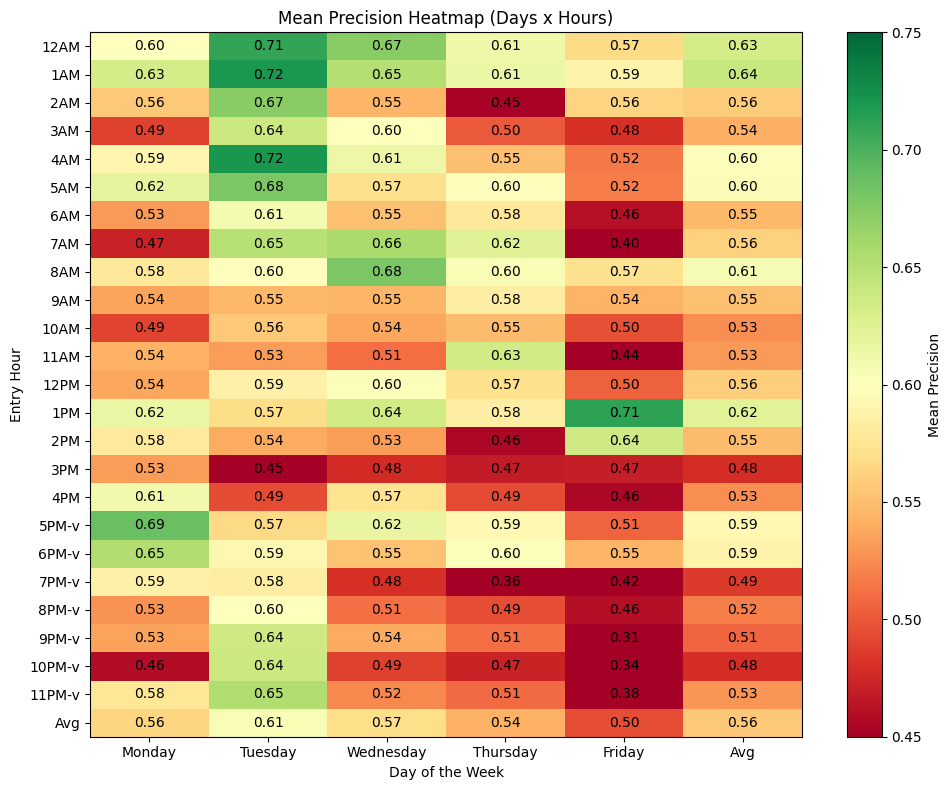

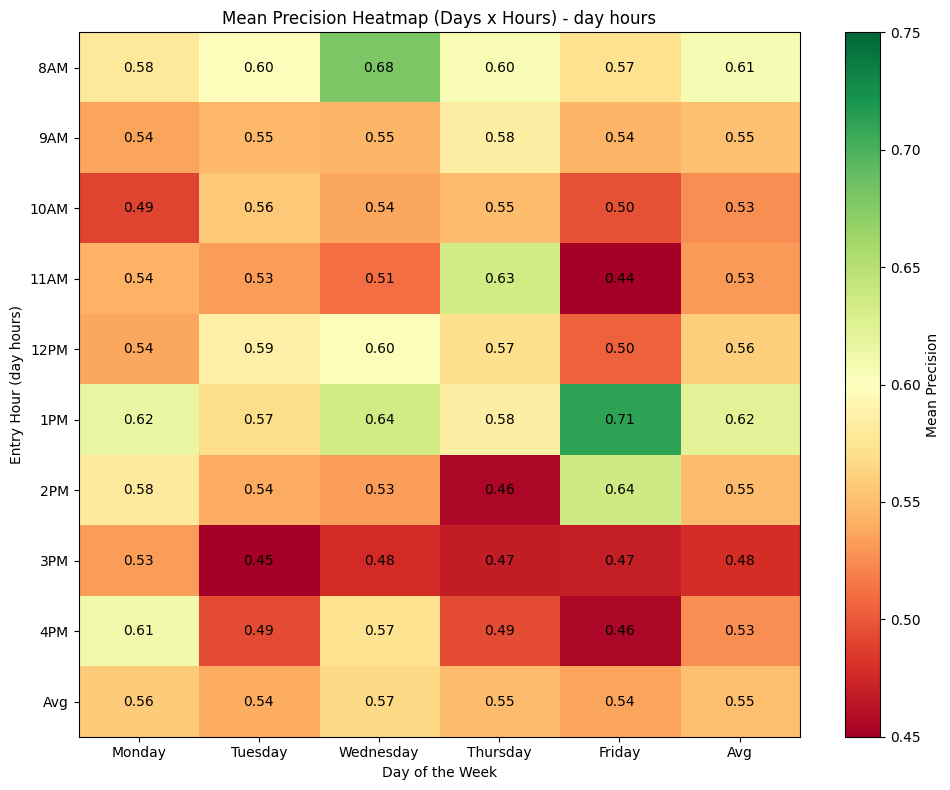

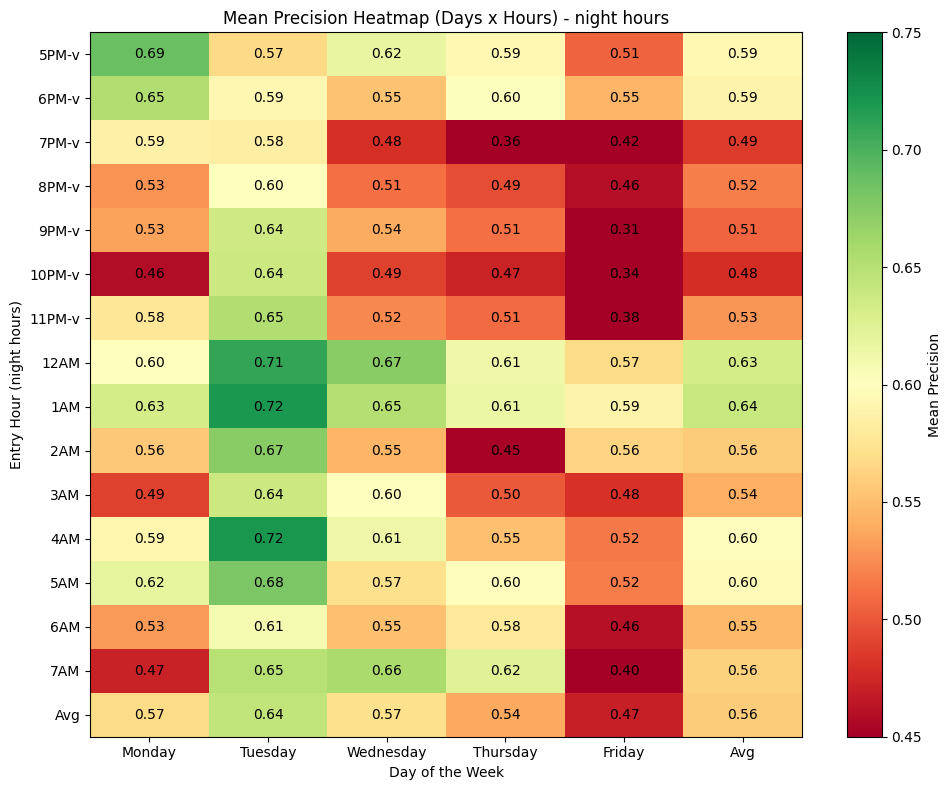

In [19]:
###############################################
# Heatmap (days x hours)
###############################################

base_data = np.zeros((len(hours), len(days))) # Create the base 2D array (Days x Hours)
for hour_index, _ in hours.items():
    for day_index, _ in days.items():
        # Calculate mean precision over all models and horizons for a given hour and day
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for model in models
            for horizon in horizons
        ]
        base_data[hour_index, day_index] = np.mean(precisions)

# Compute extended data and prepare labels
extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=day_labels,
                      y_labels=hour_labels,
                      xlabel="Day of the Week",
                      ylabel="Entry Hour",
                      title="Mean Precision Heatmap (Days x Hours)")


###############################################
# Heatmap (Days x Hours) - Only day hours (8AM - 4PM)
###############################################

base_data = np.zeros((len(day_hours), len(days)))

for i, (hour_index, _) in enumerate(day_hours.items()):
    for j, (day_index, _) in enumerate(days.items()):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for model in models
            for horizon in horizons
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data,
                      x_labels=day_labels,
                      y_labels=day_hours_labels,
                      xlabel="Day of the Week",
                      ylabel="Entry Hour (day hours)",
                      title="Mean Precision Heatmap (Days x Hours) - day hours")

###############################################
# Heatmap (Days x Hours) - Only night hours (5PM - 7AM)
###############################################

base_data = np.zeros((len(night_hours), len(days)))

for i, (hour_index, _) in enumerate(night_hours.items()):
    for j, (day_index, _) in enumerate(days.items()):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for model in models
            for horizon in horizons
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data,
                      x_labels=day_labels,
                      y_labels=night_hours_labels,
                      xlabel="Day of the Week",
                      ylabel="Entry Hour (night hours)",
                      title="Mean Precision Heatmap (Days x Hours) - night hours")


## Heatmap (Models x hours)

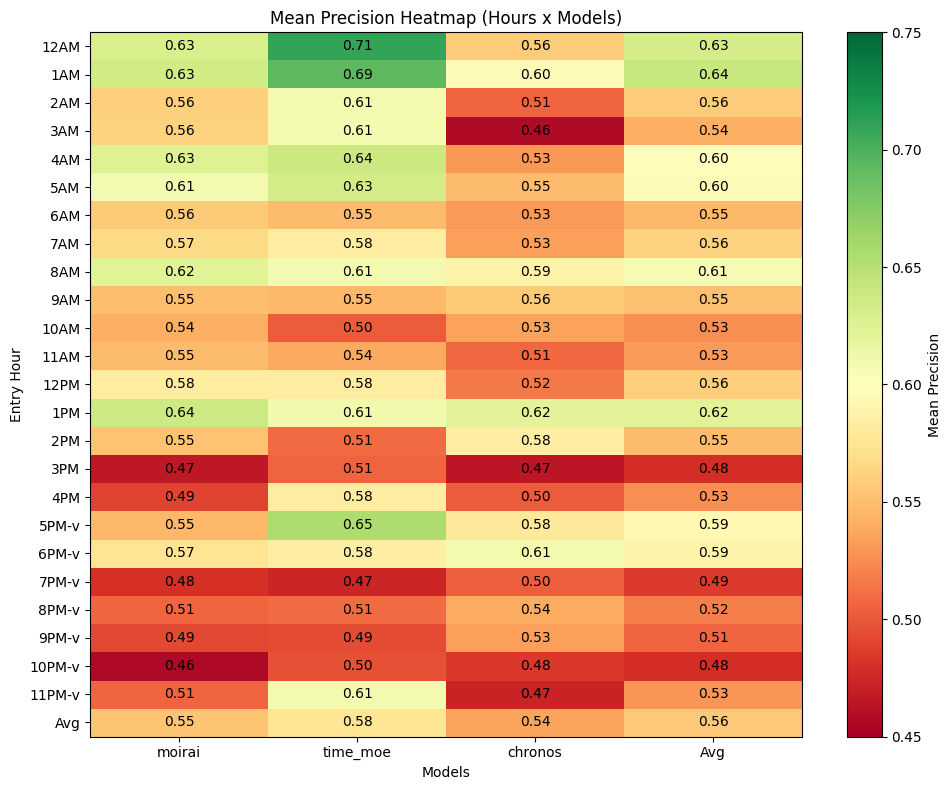

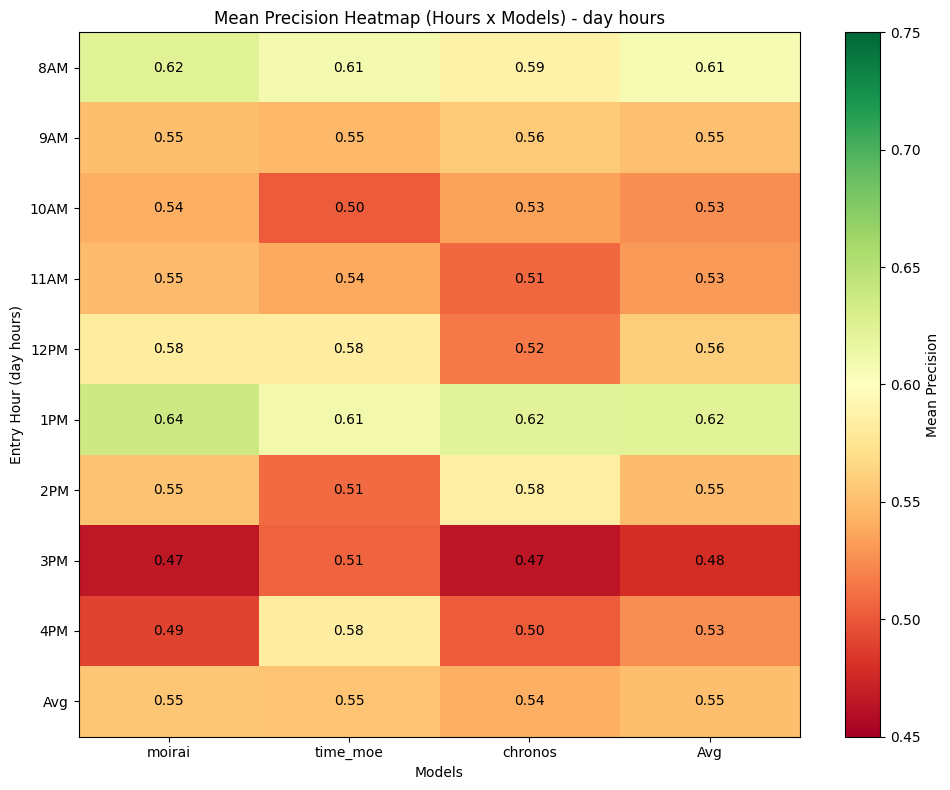

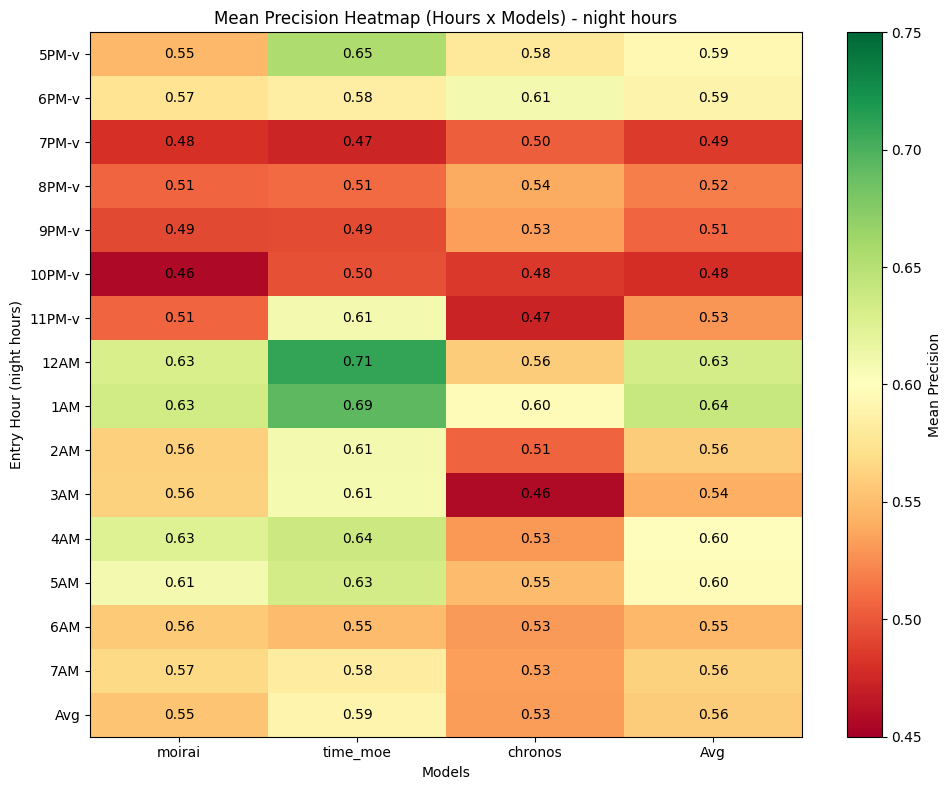

In [20]:
###############################################
# Heatmap (Models x Hours)
###############################################

base_data = np.zeros((len(hours), len(models)))  # Create the base 2D array (hours x models)

for i, (hour_index, _) in enumerate(hours.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for horizon in horizons
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=hour_labels,
                      xlabel="Models",
                      ylabel="Entry Hour",
                      title="Mean Precision Heatmap (Hours x Models)")

###############################################
# Heatmap (Models x Hours) - Only Day Hours (8AM - 4PM)
###############################################

base_data = np.zeros((len(day_hours), len(models)))  # Create the base 2D array (day hours x models)

for i, (hour_index, _) in enumerate(day_hours.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for horizon in horizons
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=day_hours_labels,
                      xlabel="Models",
                      ylabel="Entry Hour (day hours)",
                      title="Mean Precision Heatmap (Hours x Models) - day hours")

###############################################
# Heatmap (Models x Hours) - Only Night Hours (5PM - 7AM)
###############################################

base_data = np.zeros((len(night_hours), len(models)))  # Create the base 2D array (night hours x models)

for i, (hour_index, _) in enumerate(night_hours.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for horizon in horizons
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=night_hours_labels,
                      xlabel="Models",
                      ylabel="Entry Hour (night hours)",
                      title="Mean Precision Heatmap (Hours x Models) - night hours")

## Heatmap (Models x horizon)

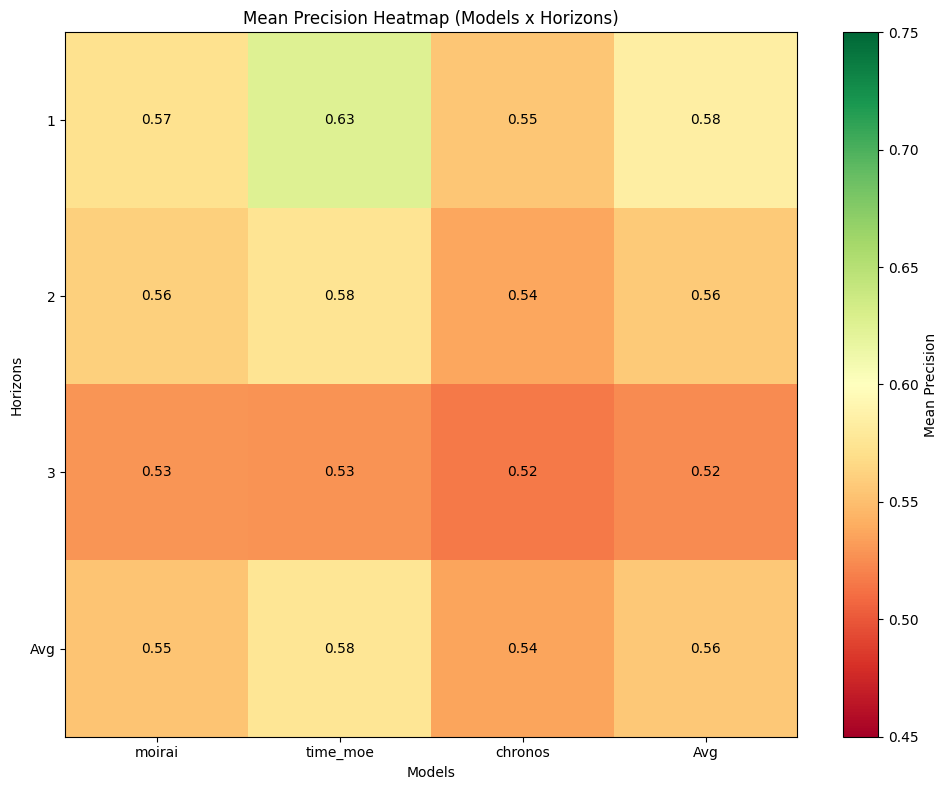

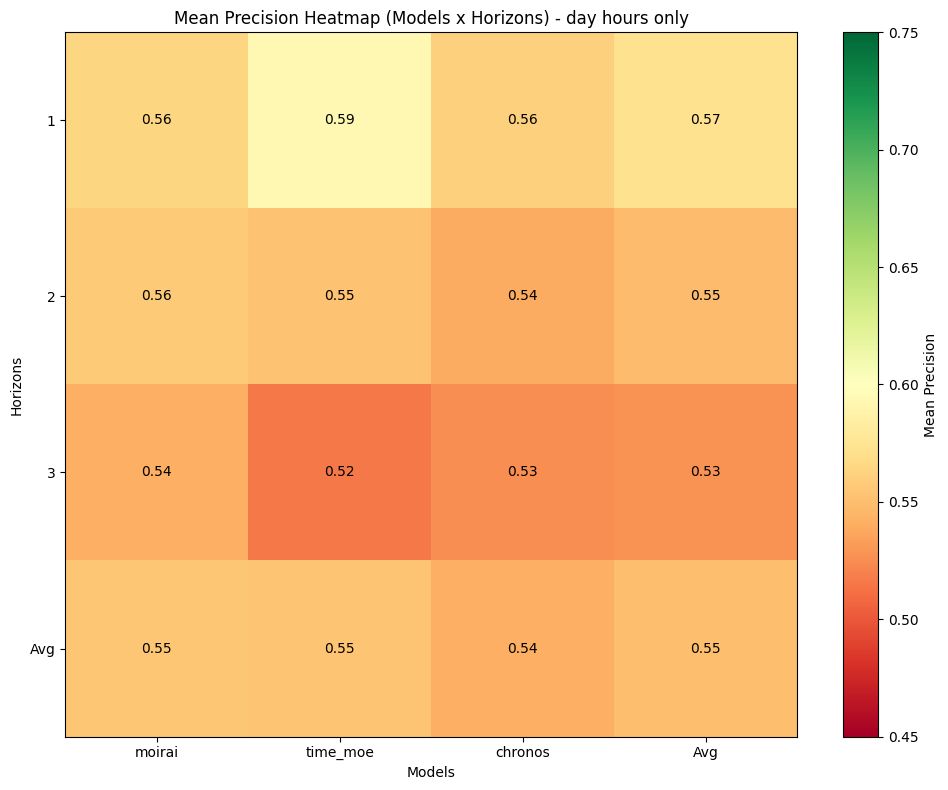

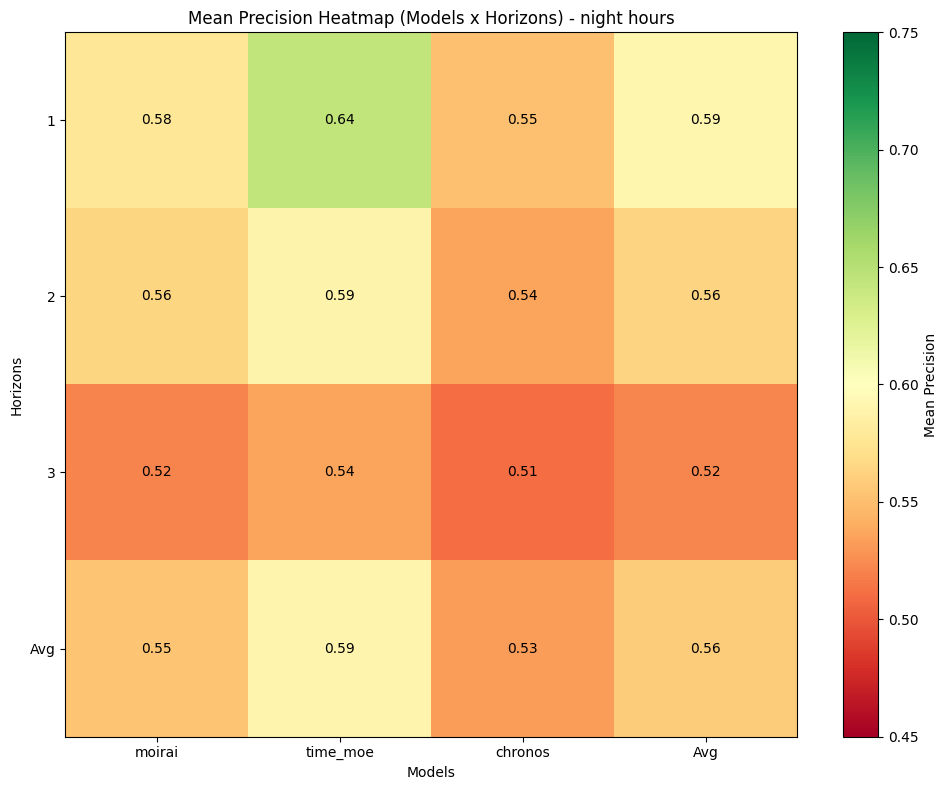

In [21]:
###############################################
# Heatmap (Models x Horizons)
###############################################

base_data = np.zeros((len(horizons), len(models)))  # Create the base 2D array (models x horizons)

for i, horizon in enumerate(horizons):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for hour_index in hours
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=horizons_label,
                      xlabel="Models",
                      ylabel="Horizons",
                      title="Mean Precision Heatmap (Models x Horizons)")

###############################################
# Heatmap (Models x Horizons) - Only Day Hours (8AM - 4PM)
###############################################

base_data = np.zeros((len(horizons), len(models)))  # Create the base 2D array (models x horizons)

for i, horizon in enumerate(horizons):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for hour_index, _ in day_hours.items()
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=horizons_label,
                      xlabel="Models",
                      ylabel="Horizons",
                      title="Mean Precision Heatmap (Models x Horizons) - day hours only")

###############################################
# Heatmap (Models x Horizons) - Only Night Hours (5PM - 7AM)
###############################################

base_data = np.zeros((len(horizons), len(models)))  # Create the base 2D array (models x horizons)

for i, horizon in enumerate(horizons):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for day_index in days
            for hour_index, _ in night_hours.items()
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=horizons_label,
                      xlabel="Models",
                      ylabel="Horizons",
                      title="Mean Precision Heatmap (Models x Horizons) - night hours")


## Heatmap (Models x days)

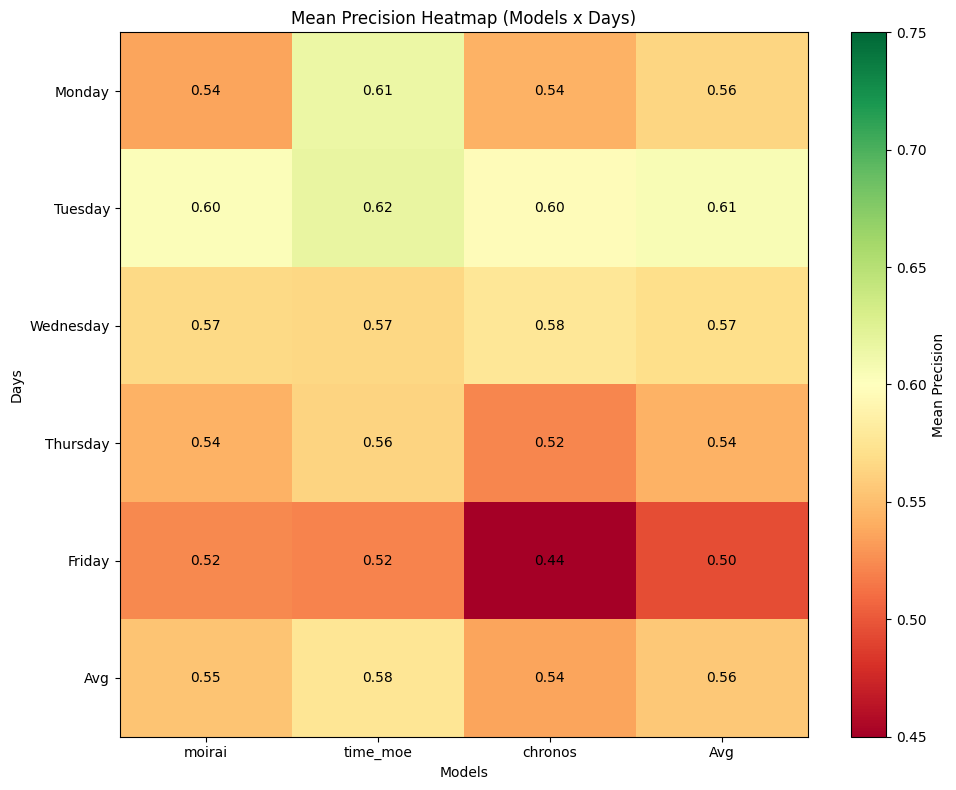

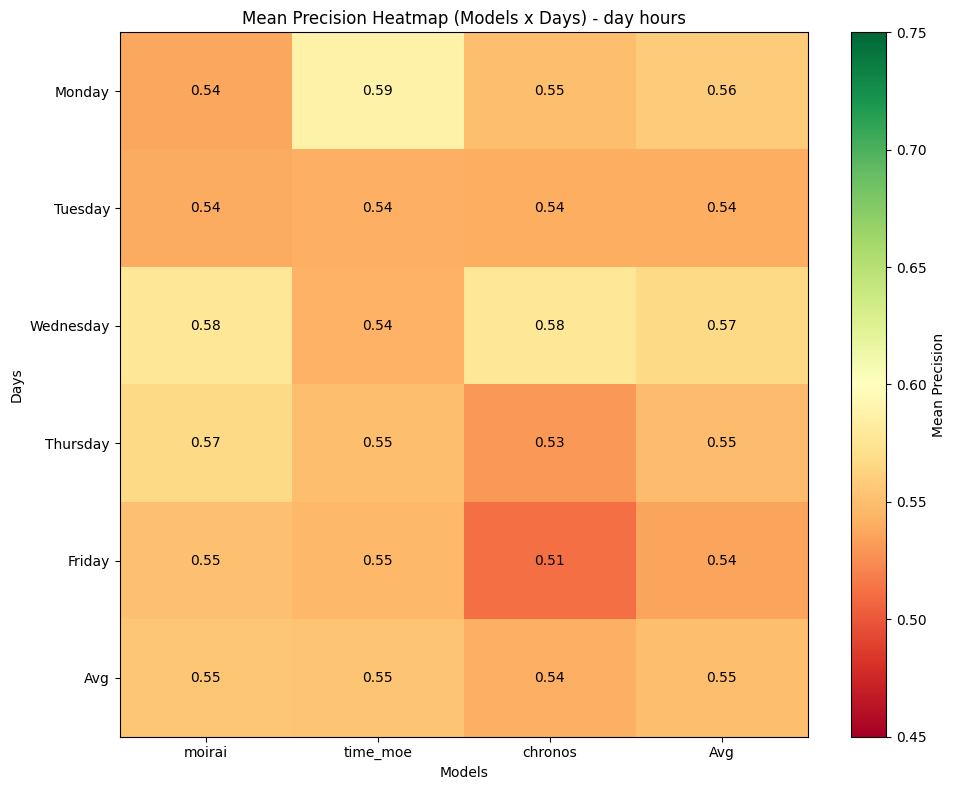

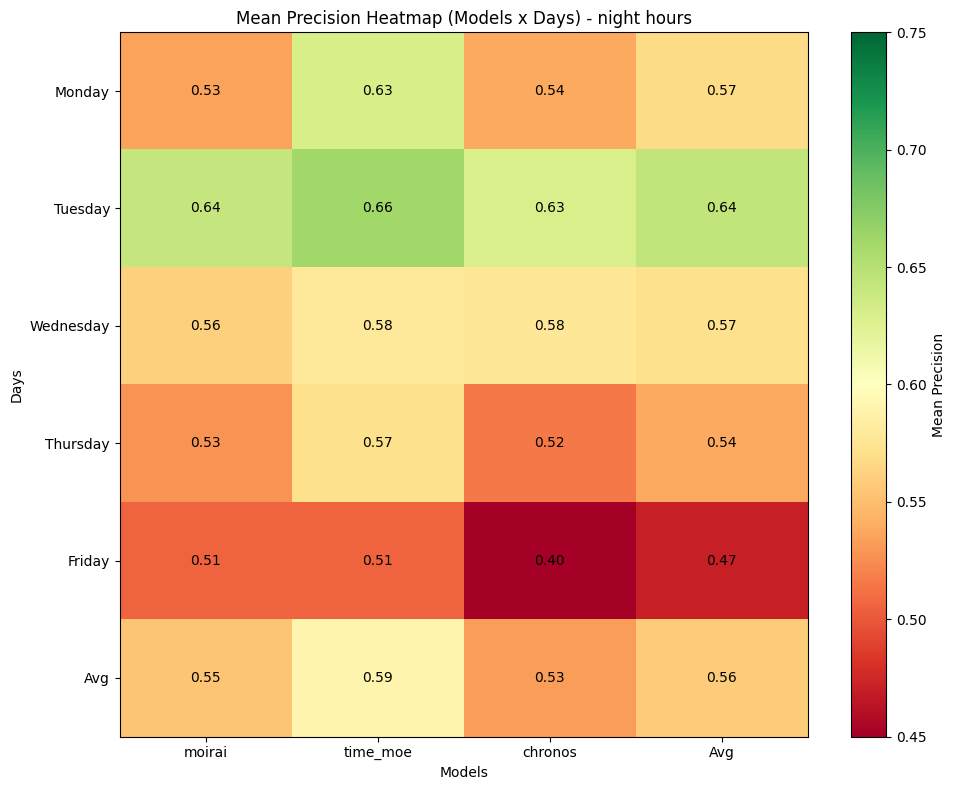

In [22]:
###############################################
# Heatmap (Models x Days)
###############################################

base_data = np.zeros((len(days), len(models)))  # Create the base 2D array (models x days)

for i, (day_index, _) in enumerate(days.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for horizon in horizons
            for hour_index in hours
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=day_labels,
                      xlabel="Models",
                      ylabel="Days",
                      title="Mean Precision Heatmap (Models x Days)")

###############################################
# Heatmap (Models x Days) - Only Day Hours (8AM - 4PM)
###############################################

base_data = np.zeros((len(days), len(models)))  # Create the base 2D array (models x days)

for i, (day_index, _) in enumerate(days.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for horizon in horizons
            for hour_index, _ in day_hours.items()
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=day_labels,
                      xlabel="Models",
                      ylabel="Days",
                      title="Mean Precision Heatmap (Models x Days) - day hours")

###############################################
# Heatmap (Models x Days) - Only Night Hours (5PM - 7AM)
###############################################

base_data = np.zeros((len(days), len(models)))  # Create the base 2D array (models x days)

for i, (day_index, _) in enumerate(days.items()):
    for j, model in enumerate(models):
        precisions = [
            heatmaps[f"{model}_{day_index}_{hour_index}_{horizon}"]
            for horizon in horizons
            for hour_index, _ in night_hours.items()
        ]
        base_data[i, j] = np.mean(precisions)

extended_data = create_extended_heatmap_data(base_data)

plot_extended_heatmap(extended_data, 
                      x_labels=models,
                      y_labels=day_labels,
                      xlabel="Models",
                      ylabel="Days",
                      title="Mean Precision Heatmap (Models x Days) - night hours")

## I don't know what is below for the moment

In [ ]:
days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}
hours = {
    10: "10AM",
    11: "11AM",
    12: "12PM",
    13: "1PM",
}
def plot_cut(future, day, hour):
    df = pd.concat([
        precision(f"{future}_future_moirai_rf.csv", day = day, hour = hour).T,
        precision(f"{future}_future_moirai_moe_rf.csv", day = day, hour = hour).T,
        precision(f"{future}_future_time_moe_rf.csv", day = day, hour = hour).T,
        precision(f"{future}_future_moirai_rf.csv", rf = True, day = day, hour = hour).T
        ], axis=1)

    df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
    df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M", "RF"]

    if day is None or hour is None:
        df.plot(
            title=f"{future.upper()} Future - Test Set",
            xlabel="Horizon",
            ylabel="Precision",
            ylim=(0, 1.1)
        )

        plt.savefig(f"plots/{future}_future_rf.png")
    else:
        df.plot(
            title=f"{future.upper()} Future - Test Set - {days[day]} - {hours[hour]}",
            xlabel="Horizon",
            ylabel="Precision",
            ylim=(0, 1.1)
        )

        plt.savefig(f"plots/{future}_future_{days[day]}_{hours[hour]}_rf.png")

In [ ]:
plot_cut("es", None, None)

In [ ]:
for day in range(5):
    for hour in range(10, 14):
        plot_cut("es", day, hour)

In [ ]:
!zip -r plots.zip plots

In [ ]:
df = pd.concat([precision("es_future_final_moirai.csv").T, precision("es_future_final_moirai_moe.csv").T, precision("es_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - All points",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1.1)
)

In [ ]:
df = pd.concat([precision("es_future_final_moirai.csv").T, precision("es_future_final_moirai_moe.csv").T, precision("es_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - All points",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv").T, precision("gc_future_final_moirai_moe.csv").T, precision("gc_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - All points",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - All points",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

# SHAP

In [23]:
import pandas as pd
import ast

features = ["ATR_10", "RSI", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]

data = pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0)
data.dropna(inplace=True)

# Assuming your DataFrame is named 'data' and the column with the lists is named 'score'

# Step 1: Convert the string representation of lists into actual lists
data['score'] = data['score'].apply(ast.literal_eval)
data['APE'] = data['APE'].apply(ast.literal_eval)
data['SIGN'] = data['SIGN'].apply(ast.literal_eval)


# Step 2: Create a DataFrame from the lists and expand the columns
score_df = pd.DataFrame(data['score'].tolist(), index=data.index)
ape_df = pd.DataFrame(data['APE'].tolist(), index=data.index)
sign_df = pd.DataFrame(data['SIGN'].tolist(), index=data.index)

# Step 3: Rename the columns to SCORE_1, SCORE_2, ..., SCORE_12
score_df.columns = [f'SCORE_{i+1}' for i in range(score_df.shape[1])]
ape_df.columns = [f'APE_{i+1}' for i in range(ape_df.shape[1])]
sign_df.columns = [f'SIGN_{i+1}' for i in range(sign_df.shape[1])]


# Step 4: (Optional) Concatenate this new DataFrame with the original DataFrame
data = pd.concat([data, score_df, ape_df, sign_df], axis=1)
data

,Close,Volume,Week,Day,Hour,ROC_Close,EMROC_Close,ROC_Volume,EMROC_Volume,ATR_10,...,SIGN_3,SIGN_4,SIGN_5,SIGN_6,SIGN_7,SIGN_8,SIGN_9,SIGN_10,SIGN_11,SIGN_12
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-01 16:00:00-06:00,3960.50,28601.5,9,2,16,0.000758,-0.000263,-0.870467,0.807977,0.015633,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2023-03-01 17:00:00-06:00,3960.00,0.0,9,2,17,-0.000252,-0.000263,-1.000000,0.758443,0.015310,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2023-03-01 18:00:00-06:00,3954.75,14682.0,9,2,18,-0.001452,-0.000295,-0.486670,0.724330,0.015310,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2023-03-01 19:00:00-06:00,3938.25,45633.0,9,2,19,-0.005492,-0.000438,inf,0.724330,0.015310,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2023-03-01 20:00:00-06:00,3944.00,17891.0,9,2,20,-0.002718,-0.000500,0.218567,0.710094,0.015310,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-12 23:00:00-06:00,6065.25,1986.0,50,3,23,0.000454,-0.000072,-0.461643,0.735117,0.006262,...,-1,1,1,1,1,1,1,-1,-1,1
2024-12-13 00:00:00-06:00,6069.75,3170.0,50,4,0,0.000536,-0.000055,-0.066549,0.713153,0.006262,...,1,1,1,1,1,1,-1,-1,-1,-1
2024-12-13 01:00:00-06:00,6070.00,5955.0,50,4,1,0.000783,-0.000032,1.998489,0.748368,0.006262,...,1,1,1,1,1,-1,-1,-1,-1,-1


In [24]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def beeswarm_plot(df, target, features):
    """
    Beeswarm Plot with TreeSHAP
    Args:
        df (pd.DataFrame): Input DataFrame containing features and target
        target (str): Name of the target column
        features (list): List of feature column names

    Returns:
        shap_values: Computed SHAP values
    """
    # Split data into features and target
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the RandomForestRegressor
    model = lgb.LGBMRegressor()
    model.fit(X, y)
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)  # Preferred API in newer versions

    # Global importance bar plot
    shap.summary_plot(shap_values.values, X_test, plot_type="bar")
    plt.show()

    # Beeswarm plot
    shap.summary_plot(shap_values.values, X_test)
    plt.show()

    return shap_values


OSError: dlopen(/Users/baudoincoispeau/Documents/Keensight/TF4FIP/venv/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /Users/baudoincoispeau/Documents/Keensight/TF4FIP/venv/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)

In [ ]:
df = data.copy()
df.dropna(inplace=True)

In [ ]:
new_df = df[df["APE_1"] < df["APE_1"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_1", features)

In [ ]:
new_df = df[df["APE_1"] < df["APE_1"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_1", features)

In [ ]:
new_df = df[df["APE_2"] < df["APE_2"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_2", features)

In [ ]:
new_df = df[df["APE_2"] < df["APE_2"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_2", features)

In [ ]:
new_df = df[df["APE_3"] < df["APE_3"].quantile(0.99)]
values = beeswarm_plot(new_df, "APE_3", features)

In [ ]:
new_df = df[df["APE_3"] < df["APE_3"].quantile(0.95)]
values = beeswarm_plot(new_df, "APE_3", features)

In [ ]:
df[features].describe()

# Discarding features

In [ ]:
df = pd.concat([precision("es_future_final_moirai.csv").T, precision("es_future_final_moirai_moe.csv").T, precision("es_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]

df.plot(
    title="ES Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("es_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("es_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("es_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="ES Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

In [ ]:
df = pd.concat([precision("gc_future_final_moirai.csv").T, precision("gc_future_final_moirai_moe.csv").T, precision("gc_future_final_time_moe.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("gc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("gc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("gc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="GC Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

In [ ]:
df = pd.concat([precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T, precision("btc_future_final_moirai.csv").T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - All points - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.3).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.3).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q3 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.5).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.5).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q5 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

df = pd.concat([precision("btc_future_final_moirai.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("btc_future_final_moirai_moe.csv", threshold_column="ATR_10", quantile = 0.8).T, precision("btc_future_final_time_moe.csv", threshold_column="ATR_10", quantile = 0.8).T], axis=1)
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = ["Moirai Base", "Moirai-MoE Small", "Time-MoE 200M"]
df.plot(
    title="BTC Future - Discarding Q8 ATR_10 - Monday - 10AM-12PM",
    xlabel="Horizon",
    ylabel="Precision",
    ylim=(0, 1)
)

# Buckets

### Main function

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np


def buckets(file_path, target = "Close_denoised_standardized", horizon = 12, threshold_column=None):
    df = pd.read_csv(file_path, parse_dates = True, index_col = 0)
    df["DistanceToEMA60"] = df["DistanceToEMM60"]
    df.dropna(inplace=True)

    def atr(target, horizon = 12, threshold_column = None, q1 = 0, q2 = 0.1):
        i = 384
        TP = [0 for k in range(horizon)]
        TN = [0 for k in range(horizon)]
        FP = [0 for k in range(horizon)]
        FN = [0 for k in range(horizon)]
        if threshold_column is not None:
            low_threshold = df[threshold_column].quantile(q1)
            high_threshold = df[threshold_column].quantile(q2)

        # -13 is used to avoid predicting the next 12 hours for our last data point.
        # Our last data point represents an hour. Starting the prediction at this hour is not possible because we could not verify if the prediction is correct or not. 
        while i < len(df)-13:
            try:
                index = df.index[i]
                # Filter out all the rows that have a value in their threshold_column that is above the high_threshold or below the low_threshold.
                if threshold_column is not None and (df[threshold_column].iloc[i] > high_threshold or df[threshold_column].iloc[i] < low_threshold):
                    i += 1
                    continue
                # If the value in the threshold column is withing the range of the high and low thresholds, we proceed.
                base = df[target].iloc[i] # we extract the value of the close denoised standardized at the current index.
                signs = list()
                for j in range(1, horizon+1):
                    y = df[target].iloc[i+j]
                    signs.append(int(np.sign(base-y)))
                # we jump to the next hour
                i+=1
                pred_signs = ast.literal_eval(df["SIGN"].iloc[i])
                for j in range(horizon):
                    if pred_signs[j] == 1 and signs[j] == -1:
                        TN[j] += 1
                    elif pred_signs[j] == 1:
                        TP[j] += 1
                    elif pred_signs[j] == -1 and signs[j] == -1:
                        FP[j] += 1
                    elif pred_signs[j] == -1:
                        FN[j] += 1
            except Exception as e:
                print(i)
                break
        return list(map(lambda x: x[0]/(x[0]+x[1]), zip(TP, FP)))
    
    # compute the precision for each ventile
    first_df = []
    for ventile in range(20):
        temp = pd.DataFrame(atr(target, horizon, threshold_column, q1 = ventile/20, q2 = (ventile+1)/20)).T
        first_df.append(temp)
    
    # This dataframe is for the baseline
    second_df = pd.DataFrame(atr(target, horizon)).T
    final_df = pd.concat(first_df + [second_df], axis=0)

    return final_df

### Plot for ATR_10

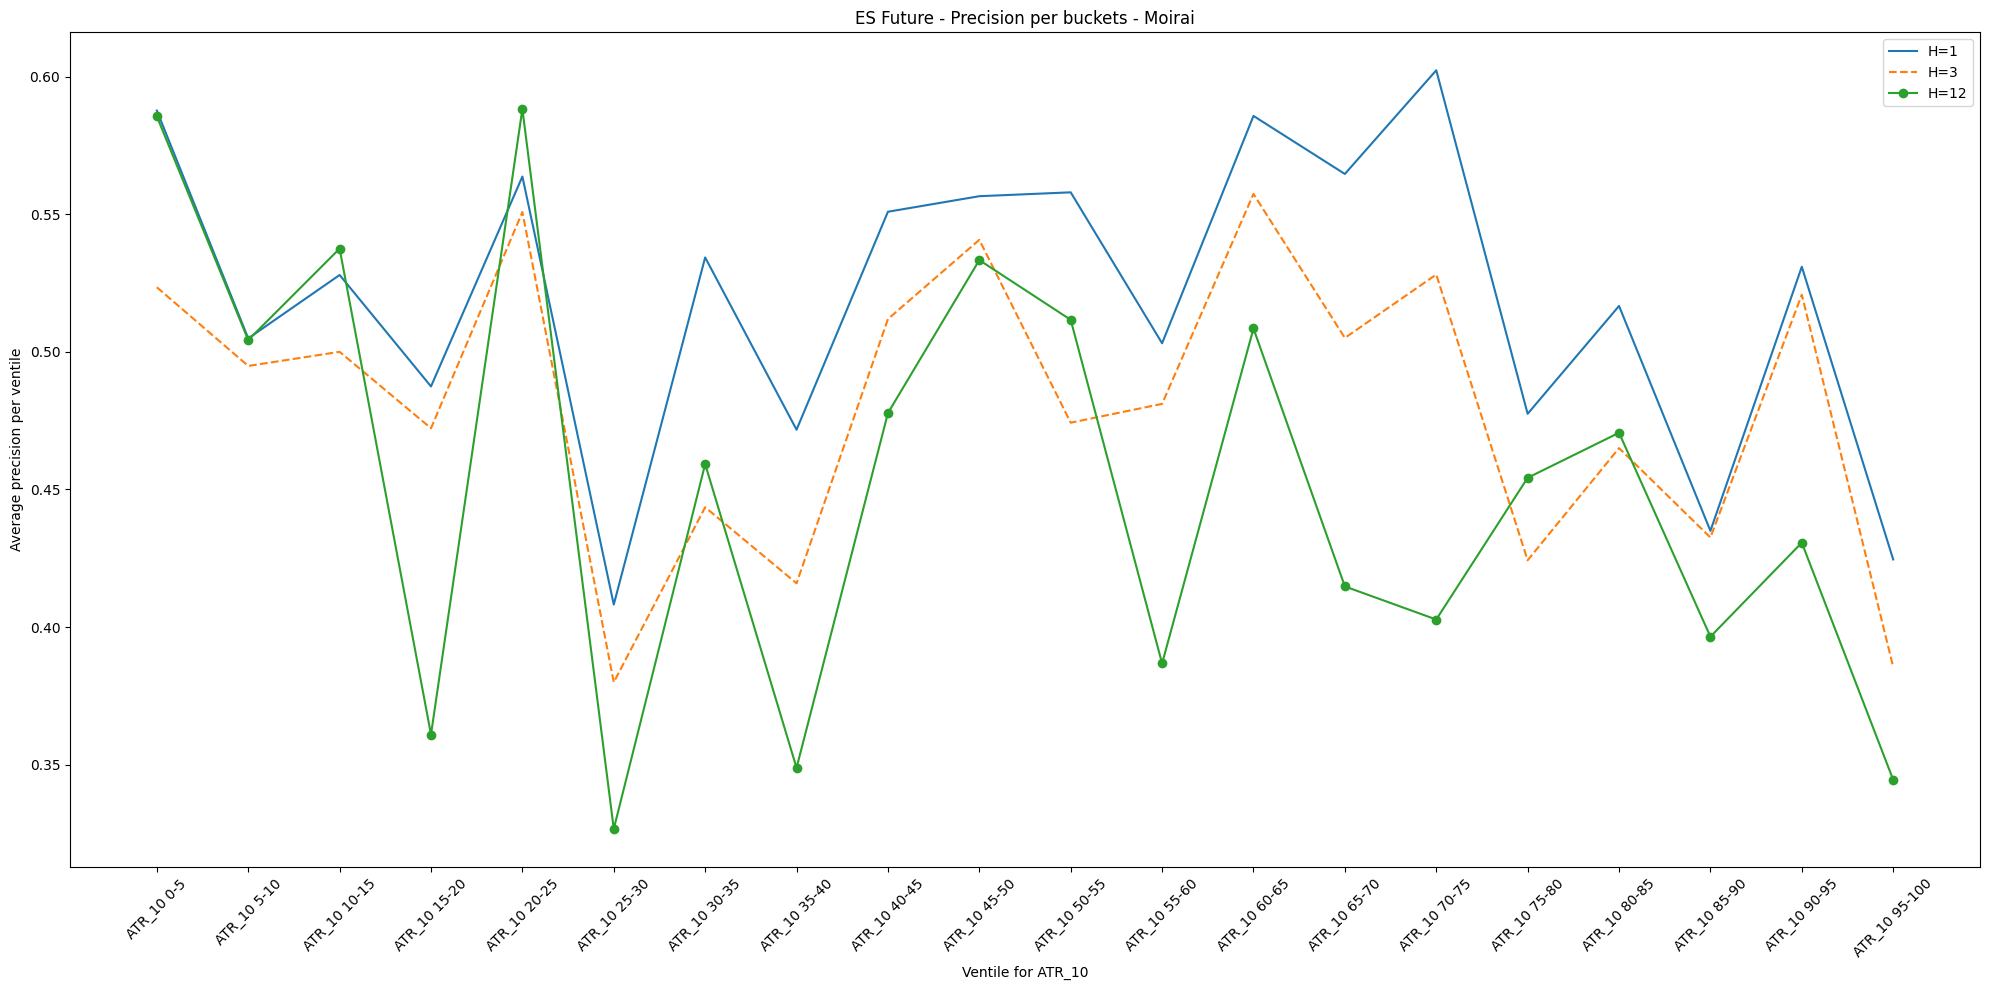

In [ ]:
import matplotlib.pyplot as plt

###############################################
# Constants

bucket_labels = [f"ATR_10 {i*5}-{(i+1)*5}" for i in range(20)]

###############################################

# Call the buckets function with horizon=12 using ATR_10 as threshold_column.
df_moirai = buckets("es_future_final_moirai.csv", horizon=12, threshold_column="ATR_10")

# The buckets function returns 21 rows: 20 ventiles (quantile buckets) + 1 baseline.
# We drop the baseline (the last row).
df_moirai = df_moirai.iloc[:-1]

# Transpose so that rows represent horizon steps (H=1 to H=12) and columns represent the ventiles.
df_moirai = df_moirai.T

# Reset the index to represent horizon steps 1 to 12.
df_moirai.index = pd.RangeIndex(start=1, stop=df_moirai.index.stop + 1, step=1)

# Set column names for the 20 ventiles (20-quantiles).
df_moirai.columns = bucket_labels

# Extract the precision values for horizons H=1, H=3, and H=12.
prec_H1_moirai = df_moirai.loc[1]   # H=1 (first forecast step)
prec_H3_moirai = df_moirai.loc[3]   # H=3 (third forecast step)
prec_H12_moirai = df_moirai.loc[12] # H=12 (twelfth forecast step)

###############################################

# We do the same for Time-MoE

###############################################

# Call the buckets function with horizon=12 using ATR_10 as threshold_column.
df_time_moe = buckets("es_future_final_time_moe.csv", horizon=12, threshold_column="ATR_10")

# The buckets function returns 21 rows: 20 ventiles (quantile buckets) + 1 baseline.
# We drop the baseline (the last row).
df_time_moe = df_time_moe.iloc[:-1]

# Transpose so that rows represent horizon steps (H=1 to H=12) and columns represent the ventiles.
df_time_moe = df_time_moe.T

# Reset the index to represent horizon steps 1 to 12.
df_time_moe.index = pd.RangeIndex(start=1, stop=df_time_moe.index.stop + 1, step=1)

# Set column names for the 20 ventiles (20-quantiles).
bucket_labels = [f"ATR_10 {i*5}-{(i+1)*5}" for i in range(20)]
df_time_moe.columns = bucket_labels

# Extract the precision values for horizons H=1, H=3, and H=12.
prec_H1_time_moe = df_time_moe.loc[1]   # H=1 (first forecast step)
prec_H3_time_moe = df_time_moe.loc[3]   # H=3 (third forecast step)
prec_H12_time_moe = df_time_moe.loc[12] # H=12 (twelfth forecast step)


###############################################

# We do the same for Chronos

###############################################

# Call the buckets function with horizon=12 using ATR_10 as threshold_column.
df_chronos = buckets("es_future_final_chronos.csv", horizon=12, threshold_column="ATR_10")

# The buckets function returns 21 rows: 20 ventiles (quantile buckets) + 1 baseline.
# We drop the baseline (the last row).
df_chronos = df_chronos.iloc[:-1]

# Transpose so that rows represent horizon steps (H=1 to H=12) and columns represent the ventiles.
df_chronos = df_chronos.T

# Reset the index to represent horizon steps 1 to 12.
df_chronos.index = pd.RangeIndex(start=1, stop=df_chronos.index.stop + 1, step=1)

# Set column names for the 20 ventiles (20-quantiles).
bucket_labels = [f"ATR_10 {i*5}-{(i+1)*5}" for i in range(20)]
df_chronos.columns = bucket_labels

# Extract the precision values for horizons H=1, H=3, and H=12.
prec_H1_chronos = df_chronos.loc[1]   # H=1 (first forecast step)
prec_H3_chronos = df_chronos.loc[3]   # H=3 (third forecast step)
prec_H12_chronos = df_chronos.loc[12] # H=12 (twelfth forecast step)

###############################################




# Plot the results.
plt.figure(figsize=(20, 10))

# Replace this part to have the prec_H1, prec_H3, and prec_H12 for each model with a different color for each.
# So there is 9 plot to do in total

plt.plot(bucket_labels, prec_H1, linestyle='-', marker=None, label="H=1")    # plain line for H=1
plt.plot(bucket_labels, prec_H3, linestyle='--', marker=None, label="H=3")   # dash line for H=3
plt.plot(bucket_labels, prec_H12, linestyle='-', marker='o', label="H=12")   # point line for H=12


plt.title("ES Future - Precision per buckets")
plt.xlabel("Ventile for ATR_10")
plt.ylabel("Average precision per ventile")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Attempt to create a function which generate 9 different plots

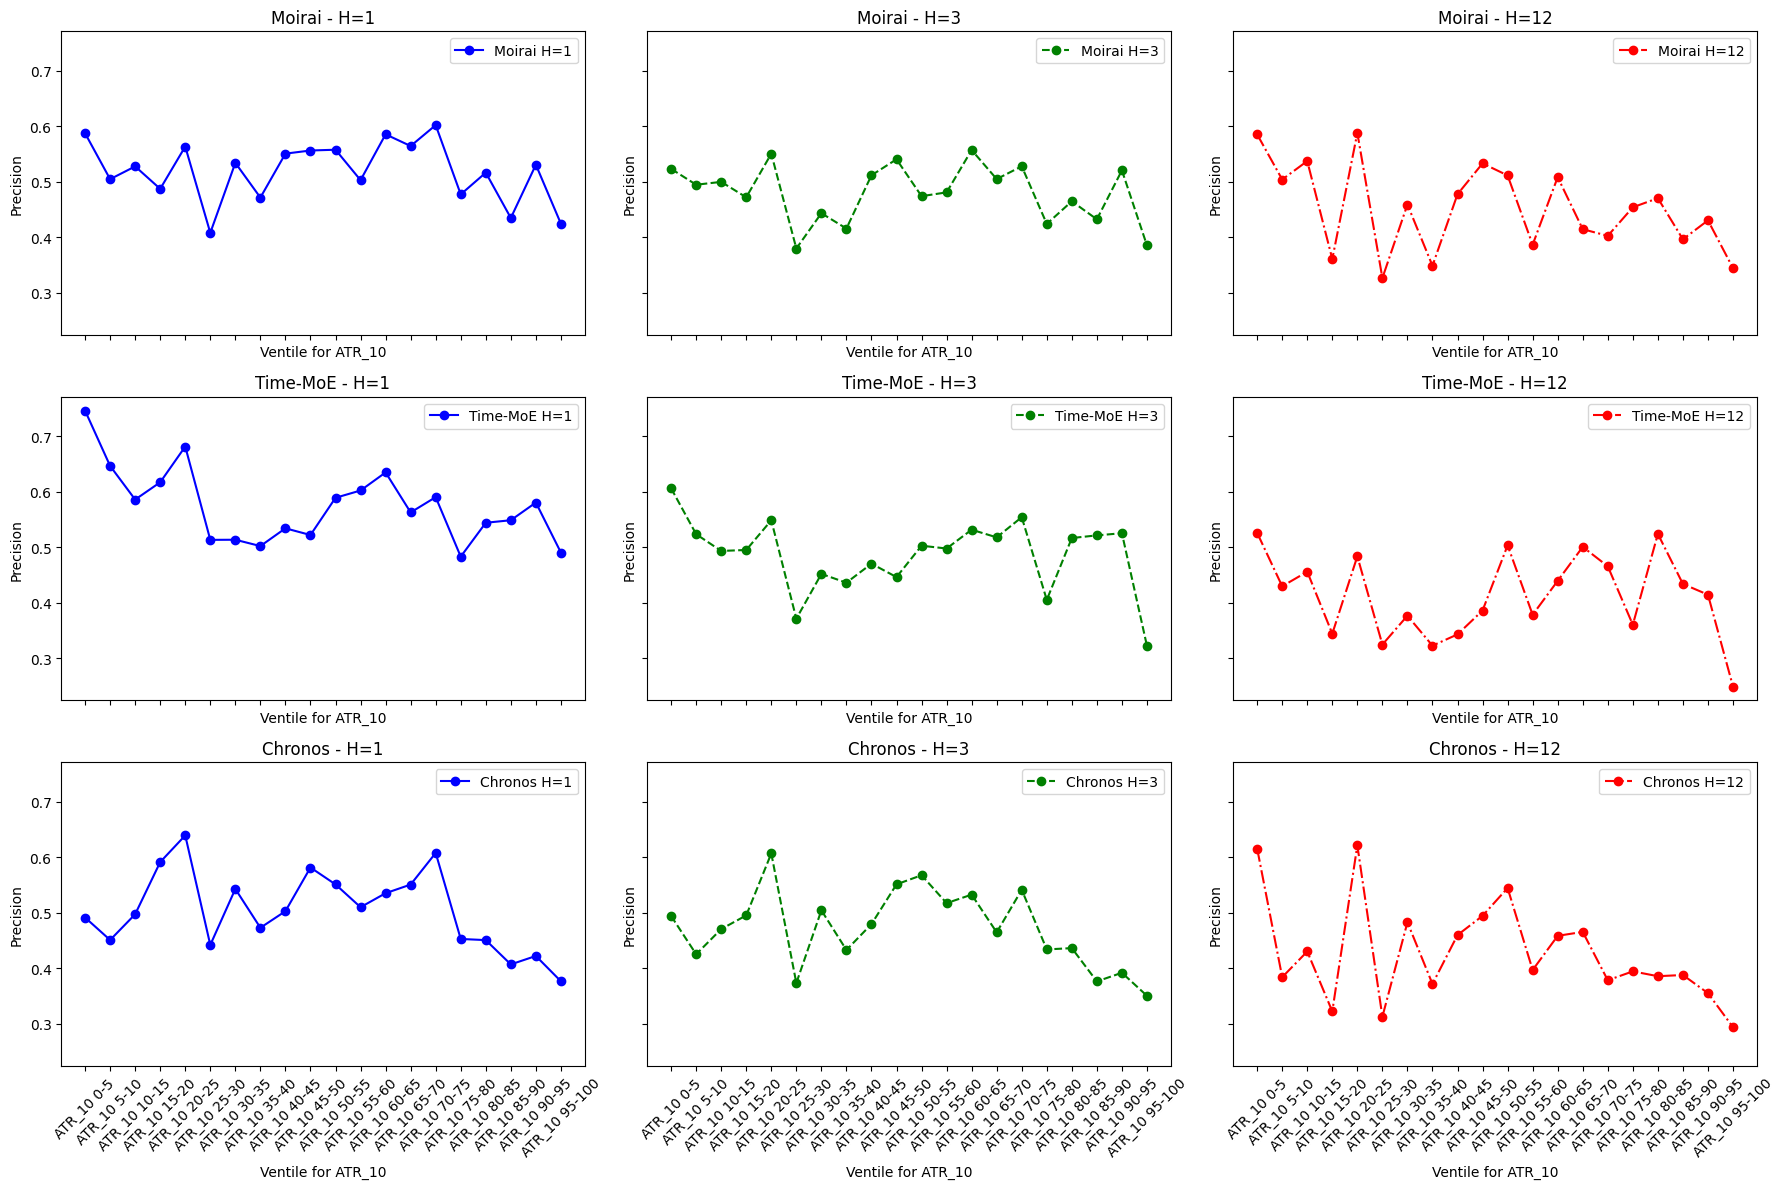

In [49]:
import matplotlib.pyplot as plt

###############################################
# Constants
bucket_labels = [f"ATR_10 {i*5}-{(i+1)*5}" for i in range(20)]

###############################################
# Define a function to process models
def process_model(file_name):
    df = buckets(file_name, horizon=12, threshold_column="ATR_10")
    df = df.iloc[:-1]  # Drop the baseline
    df = df.T  # Transpose to have horizons as rows
    df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
    df.columns = bucket_labels
    return df.loc[1], df.loc[3], df.loc[12]  # Extract precision values for H1, H3, H12

###############################################
# Process each model
prec_H1_moirai, prec_H3_moirai, prec_H12_moirai = process_model("es_future_final_moirai.csv")
prec_H1_time_moe, prec_H3_time_moe, prec_H12_time_moe = process_model("es_future_final_time_moe.csv")
prec_H1_chronos, prec_H3_chronos, prec_H12_chronos = process_model("es_future_final_chronos.csv")

###############################################
# Plot the results
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
models = [
    ("Moirai", prec_H1_moirai, prec_H3_moirai, prec_H12_moirai),
    ("Time-MoE", prec_H1_time_moe, prec_H3_time_moe, prec_H12_time_moe),
    ("Chronos", prec_H1_chronos, prec_H3_chronos, prec_H12_chronos),
]
horizons = ["H=1", "H=3", "H=12"]
linestyles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

for row, (model, prec_H1, prec_H3, prec_H12) in enumerate(models):
    for col, (horizon, prec, linestyle, color) in enumerate(zip(horizons, [prec_H1, prec_H3, prec_H12], linestyles, colors)):
        ax = axes[row, col]
        ax.plot(bucket_labels, prec, linestyle=linestyle, marker='o', color=color, label=f"{model} {horizon}")
        ax.set_title(f"{model} - {horizon}")
        ax.set_xlabel("Ventile for ATR_10")
        ax.set_ylabel("Precision")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

plt.tight_layout()
plt.show()


### Attempt to create a function which generate 1 plot with 9 different lines

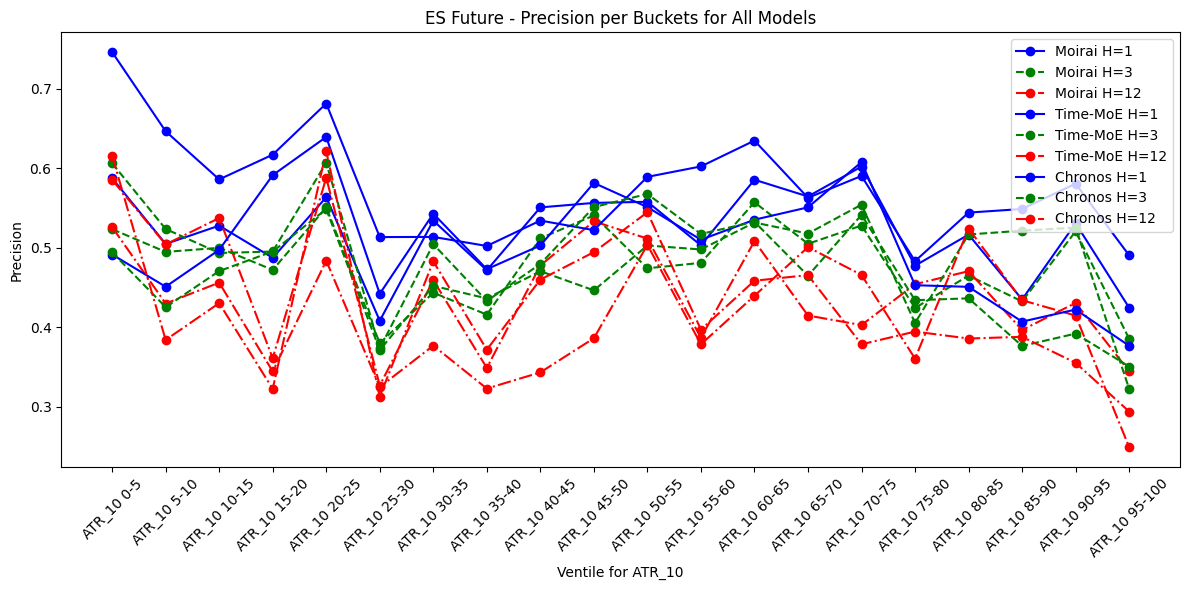

In [50]:
import matplotlib.pyplot as plt

###############################################
# Constants
bucket_labels = [f"ATR_10 {i*5}-{(i+1)*5}" for i in range(20)]

###############################################
# Define a function to process models
def process_model(file_name):
    df = buckets(file_name, horizon=12, threshold_column="ATR_10")
    df = df.iloc[:-1]  # Drop the baseline
    df = df.T  # Transpose to have horizons as rows
    df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
    df.columns = bucket_labels
    return df.loc[1], df.loc[3], df.loc[12]  # Extract precision values for H1, H3, H12

###############################################
# Process each model
prec_H1_moirai, prec_H3_moirai, prec_H12_moirai = process_model("es_future_final_moirai.csv")
prec_H1_time_moe, prec_H3_time_moe, prec_H12_time_moe = process_model("es_future_final_time_moe.csv")
prec_H1_chronos, prec_H3_chronos, prec_H12_chronos = process_model("es_future_final_chronos.csv")

###############################################
# Plot all models and horizons on a single graph
plt.figure(figsize=(12, 6))

# Define styles and labels
models = [
    ("Moirai", prec_H1_moirai, prec_H3_moirai, prec_H12_moirai),
    ("Time-MoE", prec_H1_time_moe, prec_H3_time_moe, prec_H12_time_moe),
    ("Chronos", prec_H1_chronos, prec_H3_chronos, prec_H12_chronos),
]
horizons = ["H=1", "H=3", "H=12"]
linestyles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

for model_name, prec_H1, prec_H3, prec_H12 in models:
    for horizon, prec, linestyle, color in zip(horizons, [prec_H1, prec_H3, prec_H12], linestyles, colors):
        plt.plot(bucket_labels, prec, linestyle=linestyle, marker='o', color=color, label=f"{model_name} {horizon}")

plt.title("ES Future - Precision per Buckets for All Models")
plt.xlabel("Ventile for ATR_10")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### End of plot


/var/folders/nm/0hfsx7zn6zv2n4jggw8wc0g80000gn/T/ipykernel_27386/2391949525.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 20)  # Generate 20 distinct colors


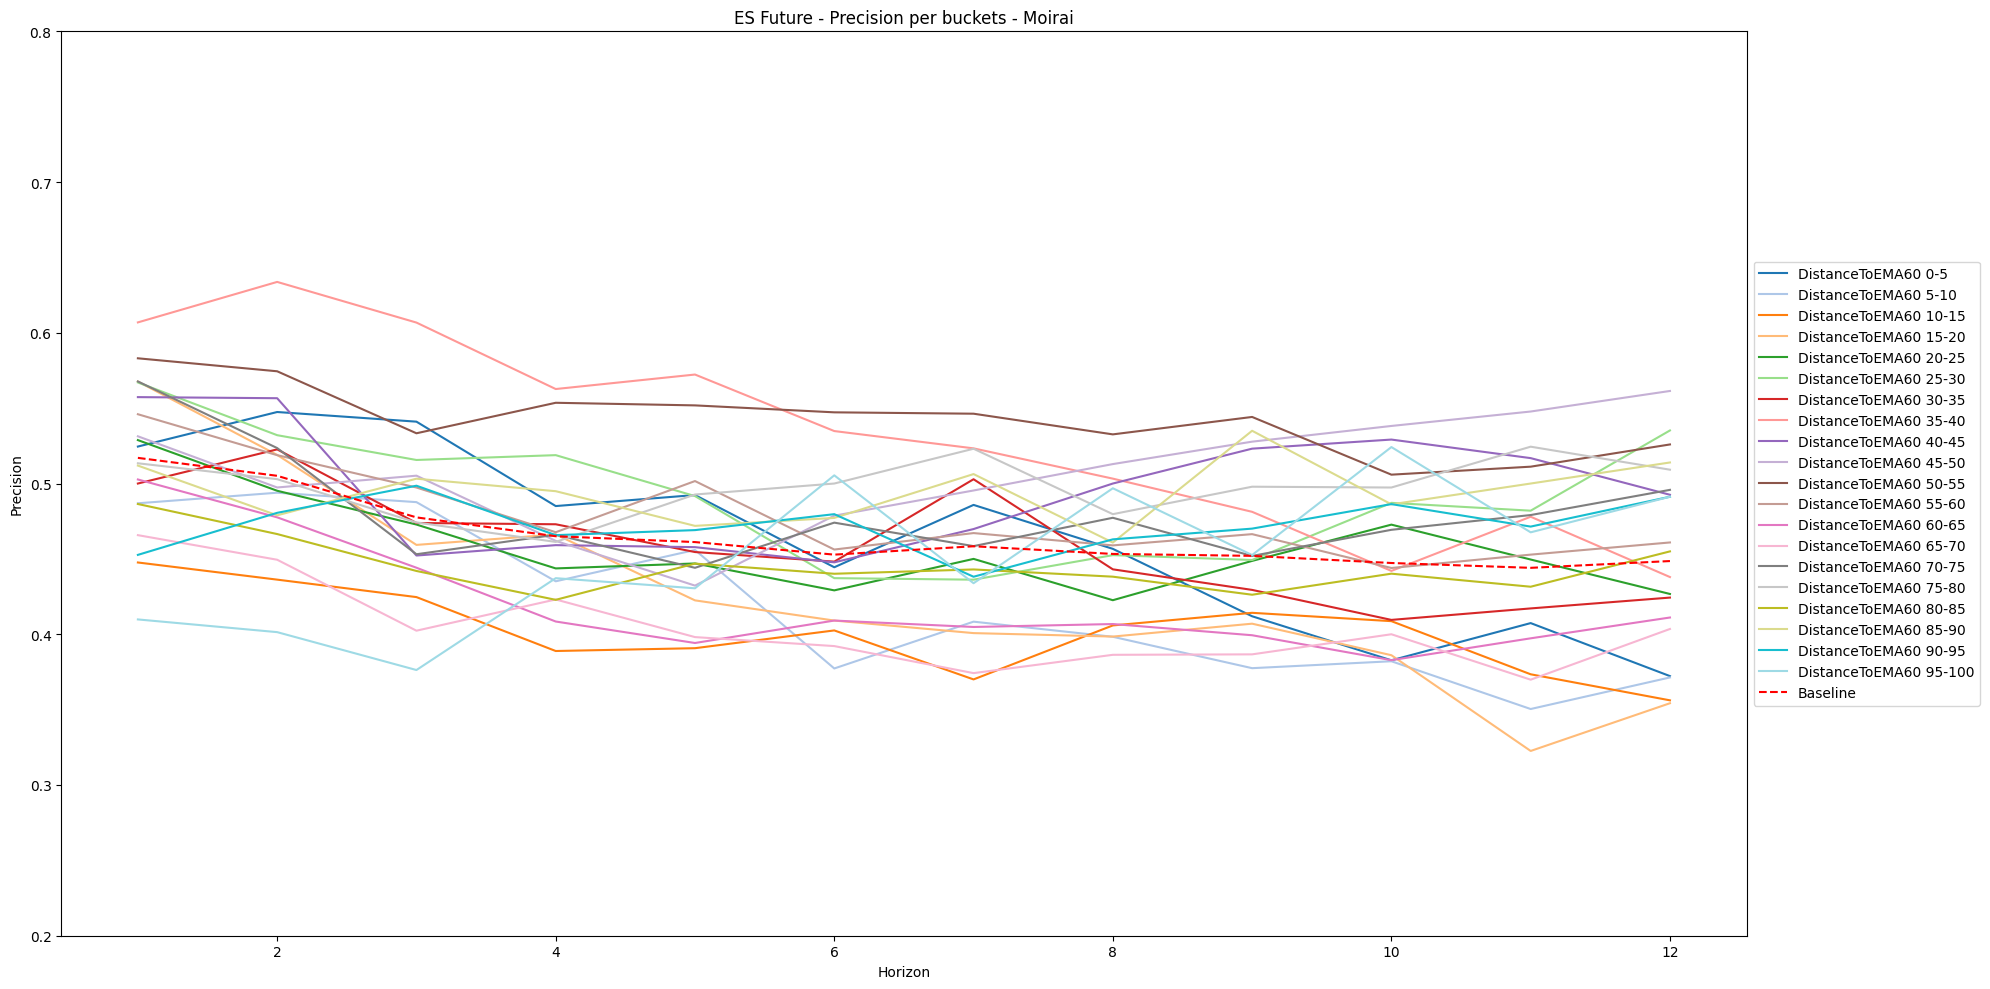

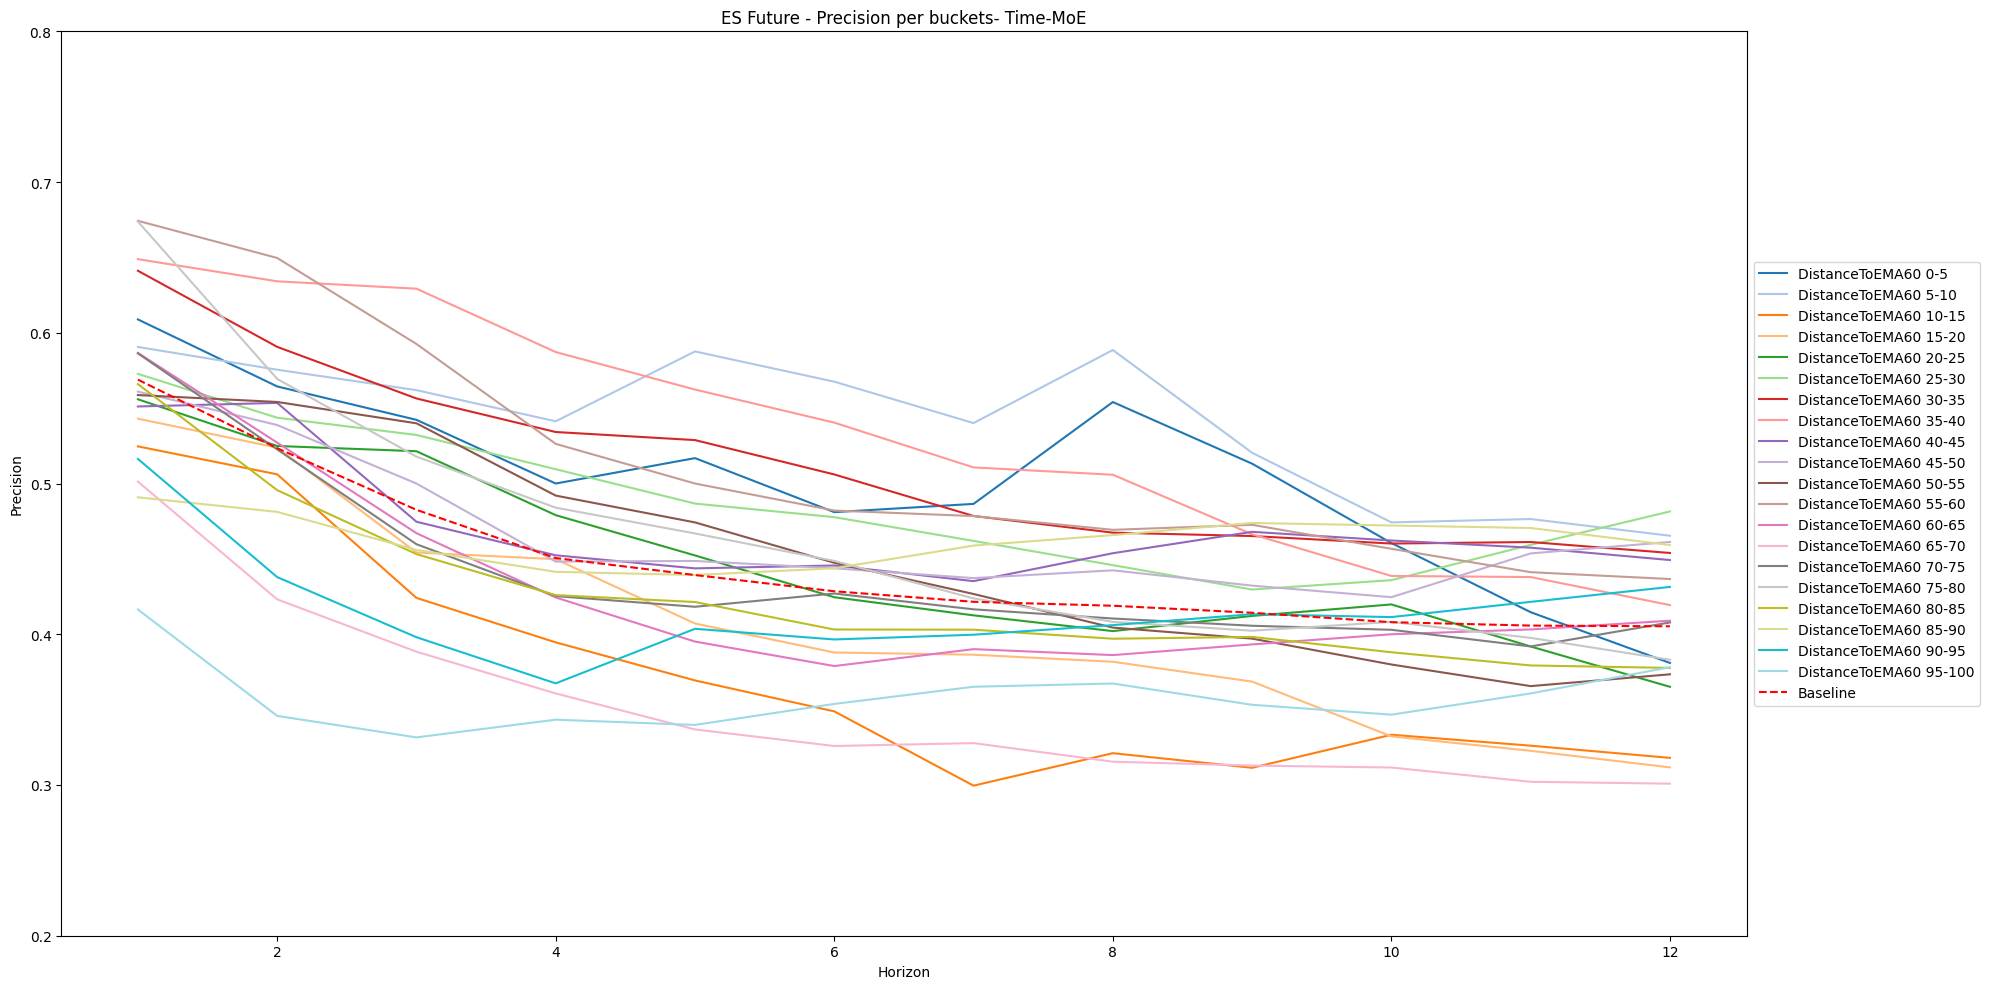

In [27]:
line_styles = ['-' for _ in range(20)] + ['--']
import matplotlib.cm as cm

# Define distinct colors using the 'tab20' colormap
colors = cm.get_cmap('tab20', 20)  # Generate 20 distinct colors
colors=[colors(i) for i in range(20)] + ["red"]
target = "DistanceToEMA60"

df = buckets("es_future_final_moirai.csv", threshold_column=target).T
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = [f"{target} {i*5}-{(i+1)*5}" for i in range(0, 20)] + ["Baseline"]
df.plot(
    title="ES Future - Precision per buckets - Moirai",
    xlabel="Horizon",
    ylabel="Precision",
    figsize=(20, 10),
    ylim=(0.2, 0.8),
    style=line_styles,
    color=colors
    )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust layout to prevent cutoff

# Show the plot
plt.show()



# df = buckets("es_future_final_moirai_moe.csv", threshold_column=target).T
# df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
# df.columns = [f"{target} {i*5}-{(i+1)*5}" for i in range(0, 20)] + ["Baseline"]
# df.plot(
#     title="ES Future - Precision per buckets - Moirai-MoE",
#     xlabel="Horizon",
#     ylabel="Precision",
#     figsize=(20, 10),
#     ylim=(0.2, 0.8),
#     style=line_styles,
#     color=colors
#     )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()  # Adjust layout to prevent cutoff

# Show the plot
plt.show()

df = buckets("es_future_final_time_moe.csv", threshold_column=target).T
df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
df.columns = [f"{target} {i*5}-{(i+1)*5}" for i in range(0, 20)] + ["Baseline"]
df.plot(
    title="ES Future - Precision per buckets- Time-MoE",
    xlabel="Horizon",
    ylabel="Precision",
    figsize=(20, 10),
    ylim=(0.2, 0.8),
    style=line_styles,
    color=colors
    )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust layout to prevent cutoff

# Show the plot
plt.show()

In [ ]:
esfuture_buckets_moirai_distance_to_ema_60

In [ ]:
# df = buckets("gc_future_final_moirai.csv", threshold_column="ATR_10").T
# df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
# df.columns = ["ATR_10 Q1", "ATR_10 Q1-Q2", "ATR_10 Q2-Q3", "ATR_10 Q3-Q4", "ATR_10 Q4-Q5", "ATR_10 Q5-Q6", "ATR_10 Q6-Q7", "ATR_10 Q7-Q8", "ATR_10 Q8-Q9", "ATR_10 Q9-Q10"]
# df.plot(
#     title="GC Future - Precision per buckets - Monday - 10AM-12PM",
#     xlabel="Horizon",
#     ylabel="Precision",
#     figsize=(20, 10)
# )


In [ ]:
# df = buckets("btc_future_final_moirai.csv", threshold_column="ATR_10").T
# df.index = pd.RangeIndex(start=1, stop=df.index.stop + 1, step=1)
# df.columns = ["ATR_10 Q1", "ATR_10 Q1-Q2", "ATR_10 Q2-Q3", "ATR_10 Q3-Q4", "ATR_10 Q4-Q5", "ATR_10 Q5-Q6", "ATR_10 Q6-Q7", "ATR_10 Q7-Q8", "ATR_10 Q8-Q9", "ATR_10 Q9-Q10"]
# df.plot(
#     title="BTC Future - Precision per buckets - Monday - 10AM-12PM",
#     xlabel="Horizon",
#     ylabel="Precision",
#     figsize=(20, 10)
# )

# Random Forest

In [ ]:
# Random forest Regressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split


features = ["ATR_10", "RSI", "Volume", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]
target = "Close_denoised"

def market_rf(file_path, features, target, horizon):
    df = pd.read_csv(file_path, parse_dates = True, index_col = 0)
    df.dropna(inplace=True)

    X = df[features][:-3]
    y = pd.concat([df[target][:-3], df[target].shift(-1)[:-3], df[target].shift(-2)[:-3], df[target].shift(-3)[:-3]], axis=1)
    y.columns = ["H=0", "H=1", "H=2", "H=3"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf1 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf2 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf3 = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        bootstrap=True,
        random_state=42
    )

    rf1.fit(X_train, y_train["H=1"])
    rf2.fit(X_train, y_train["H=2"])
    rf3.fit(X_train, y_train["H=3"])

    y_pred1 = rf1.predict(X_test)
    y_pred2 = rf2.predict(X_test)
    y_pred3 = rf3.predict(X_test)

    def get_metrics(y_test, y_pred):
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)**0.5
        print(f"MAE: {mae}, R2: {r2}, MSE: {mse}, RMSE: {rmse}")

    print("H=1")
    get_metrics(y_test["H=1"], y_pred1)
    print("H=2")
    get_metrics(y_test["H=2"], y_pred2)
    print("H=3")
    get_metrics(y_test["H=3"], y_pred3)
    return y_test, y_pred1, y_pred2, y_pred3

In [ ]:
df = pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0)

In [ ]:
X = df[features][:-3]
y = pd.concat([df[target][:-3], df[target].shift(-1)[:-3], df[target].shift(-2)[:-3], df[target].shift(-3)[:-3]], axis=1)
y.columns = ["H=0", "H=1", "H=2", "H=3"]

In [ ]:
y_test, y_pred1, y_pred2, y_pred3 = market_rf("es_future_final_moirai.csv", features, target, 1)

In [ ]:
df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

In [ ]:
rf_df = pd.concat([y_test, df1, df2, df3], axis=1)
rf_df

In [ ]:
df = pd.read_csv("es_future_final_moirai.csv", parse_dates = True, index_col = 0)
df

In [ ]:
aggregated = pd.concat([df, rf_df], axis=1)
aggregated.dropna(inplace=True)

In [ ]:
# ESFUTURE RF

import numpy as np


y_test, y_pred1, y_pred2, y_pred3 = market_rf("es_future_final_moirai.csv", features, target, 1)

df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

rf_df = pd.concat([y_test, df1, df2, df3], axis=1)


rf_df["Evolution 1"] = rf_df["H=0"] - rf_df["H=1"]
rf_df["Evolution 2"] = rf_df["H=0"] - rf_df["H=2"]
rf_df["Evolution 3"] = rf_df["H=0"] - rf_df["H=3"]

rf_df["Pred Evolution 1"] = rf_df["H=0"] - rf_df["Predictions H=1"]
rf_df["Pred Evolution 2"] = rf_df["H=0"] - rf_df["Predictions H=2"]
rf_df["Pred Evolution 3"] = rf_df["H=0"] - rf_df["Predictions H=3"]

rf_df["Evolution 1"] = rf_df["Evolution 1"].apply(np.sign)
rf_df["Evolution 2"] = rf_df["Evolution 2"].apply(np.sign)
rf_df["Evolution 3"] = rf_df["Evolution 3"].apply(np.sign)

rf_df["Pred Evolution 1"] = rf_df["Pred Evolution 1"].apply(np.sign)
rf_df["Pred Evolution 2"] = rf_df["Pred Evolution 2"].apply(np.sign)
rf_df["Pred Evolution 3"] = rf_df["Pred Evolution 3"].apply(np.sign)

es_future_moirai_rf = pd.concat([pd.read_csv("es_future_final_moirai.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
es_future_moirai_moe_rf = pd.concat([pd.read_csv("es_future_final_moirai_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
es_future_time_moe_rf = pd.concat([pd.read_csv("es_future_final_time_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)

es_future_moirai_rf.to_csv("es_future_moirai_rf.csv")
es_future_moirai_moe_rf.to_csv("es_future_moirai_moe_rf.csv")
es_future_time_moe_rf.to_csv("es_future_time_moe_rf.csv")


In [ ]:
# GCFUTURE RF

import numpy as np


y_test, y_pred1, y_pred2, y_pred3 = market_rf("gc_future_final_moirai.csv", features, target, 1)

df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

rf_df = pd.concat([y_test, df1, df2, df3], axis=1)


rf_df["Evolution 1"] = rf_df["H=0"] - rf_df["H=1"]
rf_df["Evolution 2"] = rf_df["H=0"] - rf_df["H=2"]
rf_df["Evolution 3"] = rf_df["H=0"] - rf_df["H=3"]

rf_df["Pred Evolution 1"] = rf_df["H=0"] - rf_df["Predictions H=1"]
rf_df["Pred Evolution 2"] = rf_df["H=0"] - rf_df["Predictions H=2"]
rf_df["Pred Evolution 3"] = rf_df["H=0"] - rf_df["Predictions H=3"]

rf_df["Evolution 1"] = rf_df["Evolution 1"].apply(np.sign)
rf_df["Evolution 2"] = rf_df["Evolution 2"].apply(np.sign)
rf_df["Evolution 3"] = rf_df["Evolution 3"].apply(np.sign)

rf_df["Pred Evolution 1"] = rf_df["Pred Evolution 1"].apply(np.sign)
rf_df["Pred Evolution 2"] = rf_df["Pred Evolution 2"].apply(np.sign)
rf_df["Pred Evolution 3"] = rf_df["Pred Evolution 3"].apply(np.sign)

gc_future_moirai_rf = pd.concat([pd.read_csv("gc_future_final_moirai.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
gc_future_moirai_moe_rf = pd.concat([pd.read_csv("gc_future_final_moirai_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
gc_future_time_moe_rf = pd.concat([pd.read_csv("gc_future_final_time_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)

gc_future_moirai_rf.to_csv("gc_future_moirai_rf.csv")
gc_future_moirai_moe_rf.to_csv("gc_future_moirai_moe_rf.csv")
gc_future_time_moe_rf.to_csv("gc_future_time_moe_rf.csv")

In [ ]:
# BTCFUTURE RF

import numpy as np


y_test, y_pred1, y_pred2, y_pred3 = market_rf("btc_future_final_moirai.csv", features, target, 1)

df1 = pd.DataFrame(y_pred1, columns=["Predictions H=1"])
df2 = pd.DataFrame(y_pred2, columns=["Predictions H=2"])
df3 = pd.DataFrame(y_pred3, columns=["Predictions H=3"])

df1.index = y_test.index
df2.index = y_test.index
df3.index = y_test.index

rf_df = pd.concat([y_test, df1, df2, df3], axis=1)


rf_df["Evolution 1"] = rf_df["H=0"] - rf_df["H=1"]
rf_df["Evolution 2"] = rf_df["H=0"] - rf_df["H=2"]
rf_df["Evolution 3"] = rf_df["H=0"] - rf_df["H=3"]

rf_df["Pred Evolution 1"] = rf_df["H=0"] - rf_df["Predictions H=1"]
rf_df["Pred Evolution 2"] = rf_df["H=0"] - rf_df["Predictions H=2"]
rf_df["Pred Evolution 3"] = rf_df["H=0"] - rf_df["Predictions H=3"]

rf_df["Evolution 1"] = rf_df["Evolution 1"].apply(np.sign)
rf_df["Evolution 2"] = rf_df["Evolution 2"].apply(np.sign)
rf_df["Evolution 3"] = rf_df["Evolution 3"].apply(np.sign)

rf_df["Pred Evolution 1"] = rf_df["Pred Evolution 1"].apply(np.sign)
rf_df["Pred Evolution 2"] = rf_df["Pred Evolution 2"].apply(np.sign)
rf_df["Pred Evolution 3"] = rf_df["Pred Evolution 3"].apply(np.sign)

btc_future_moirai_rf = pd.concat([pd.read_csv("btc_future_final_moirai.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
btc_future_moirai_moe_rf = pd.concat([pd.read_csv("btc_future_final_moirai_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)
btc_future_time_moe_rf = pd.concat([pd.read_csv("btc_future_final_time_moe.csv", parse_dates = True, index_col = 0), rf_df], axis=1)

btc_future_moirai_rf.to_csv("btc_future_moirai_rf.csv")
btc_future_moirai_moe_rf.to_csv("btc_future_moirai_moe_rf.csv")
btc_future_time_moe_rf.to_csv("btc_future_time_moe_rf.csv")

In [ ]:
!pip install PyWavelets

In [ ]:
df = pd.read_csv("BTC=F.csv", parse_dates = True, index_col = 0)
import pywt
import numpy as np
import pandas as pd

# Example DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_file.csv')
close_prices = df['Close'].values  # Extract the Close price as a NumPy array

# Wavelet Denoising Function
def wavelet_denoising(data, wavelet='db1', level=1):
    """
    Apply wavelet denoising to the input data.

    Parameters:
    - data: array-like, the input signal to denoise.
    - wavelet: str, type of wavelet to use (default: 'db1').
    - level: int, decomposition level (default: 1).

    Returns:
    - Denoised signal as a NumPy array.
    """
    # Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Set threshold (universal threshold)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Thresholding
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

# Apply denoising to the Close prices
denoised_close = wavelet_denoising(close_prices, wavelet='db4', level=2)

# Add denoised signal back to the DataFrame
df['Close_denoised'] = denoised_close[:len(df)]  # Ensure the length matches the DataFrame

df['Close_denoised_standardized'] = (df['Close_denoised'] - df['Close_denoised'].mean()) / df['Close_denoised'].std()
df.to_csv("BTC=F.csv")

In [ ]:
df[target].shift(-1)[:-3]

In [ ]:
y_test, y_pred = market_rf("es_future_final_moirai.csv", features, target, 2)

In [ ]:
y_test[(y_test.index == test_1.index)]

In [ ]:
test_1

In [ ]:
market_rf("es_future_final_moirai.csv", features, target, 3)

In [ ]:
0.7/0.85

In [ ]:
0.15/0.85

In [ ]:
l = [0 for i in range(100000)]

val = l[-int(len(l)*0.15):]
remaining = l[:-int(len(l)*0.15)]
train = remaining[-int(len(remaining) * 0.7/0.85):]
test = remaining[:-int(len(remaining) * 0.7/0.85)]
print(len(train), len(test), len(val))



In [ ]:
s = r"""\subsection{Monday}
\begin{figure}
    \includegraphics[width=0.5\linewidth]{plots/es_future_Monday_10AM_rf.png}
    \includegraphics[width=0.5\linewidth]{plots/es_future_Monday_11AM_rf.png}
    \includegraphics[width=0.5\linewidth]{plots/es_future_Monday_12PM_rf.png}
    \includegraphics[width=0.5\linewidth]{plots/es_future_Monday_1PM_rf.png}
    \label{fig:enter-label}
\end{figure}"""

print(s)

In [ ]:
print(s.replace("Monday", "Friday"))